# Examen 1: Minería de Texto para Turismo

Guillermo Segura Gómez

Para este proyecto consideraremos el conjunto de datos recolectado por el equipo del Dr. Rafael Guerrero, profesor en la División de Ciencias Económico Administrativas de la Universidad de Guanajuato. Este conjunto de datos contiene un aproximado de diez mil opiniones de turistas en trip advisor en 10 sitios turísticos de la ciudad de Guanajuato. El objetivo es realizar las siguientes actividades y contestar las preguntas. Para esta tarea se puede usar cualquier librería o herramienta de Python (e.g., sklearn, keras, nltk, códigos de github de otras personas (citando), etc.). También puede reusar su código de tareas previas, o puede simplemente usar TfIdfVectorizer, CountVectorizer, etc. de sklearnt. 

Puede usar también SelectKBest como en el Lecture de DOR lo hizo el profesor, o usar su propio código de Chi2.Para estas actividades usted determine el número de features (palabras) de alguna forma según su intuición. Usualmente el top 10k con base en frecuencia podría ser buena elección si su hardware es suficiente para llevar a cabo las actividades. Sí su reducción es a 5k o menos términos, algo con base en Chi2, Ganancia de Información o valores TFIDFs podría venir mejor para no perder tanta información y llegar a buenas conclusiones.

## Actividades

**1. Construya estadísticas básicas respecto a la opinión de cada lugar turístico. Pre procese y limpie el texto según sus intuiciones y argumente brevemente sobre ello.**

**Considere scores de 4 a 5 como positivos, calificaciones de 3 como neutros y las de 2 a 1 como negativos. Es interesante ver:**

* (a) Promedios de calificación por lugar, y desviaciones estándar en los scores
* (b) Basado en palabras: longitud promedio de opiniones y desviaciones estándar
* (c) Histogramas de edades de opiniones por lugar
* (d) Histograma de tipo de visitantes (nacional o internacional) por lugar
* (e) Sugiere dos más interesantes para ti.

----

Lo primero que tenemos que hacer es cargar los datos en un **dataframe** de *pandas* esto ya que hace que sea muchísimo mas fácil trabajar los datos. Trabajamos con un diccionario que tenga los dataframes ya que el contenido del archivo xlsx son bastantes hojas.

Librerías necesarias

In [103]:
# Funciones necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re
import warnings
from wordcloud import WordCloud # Nube de palabras


# NLTK
import nltk
nltk.data.path.append('/Users/guillermo_sego/anaconda3/nltk_data/') # path
from nltk.corpus import stopwords

# Tokienizador
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer() # Inicializar tokenizer

# Para análisis de sentimientos
from textblob import TextBlob

# Scikit
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [14]:
# Cargar el archivo xlsx
xlsx = pd.ExcelFile('/Users/guillermo_sego/Desktop/Segundo Semestre/PLN/Data/Opiniones Tripadvisor_nlp2023(1).xlsx', engine='openpyxl')

# Diccionario para almacenar DataFrames
dfs = {}

# Leer cada hoja en un DataFrame y almacenarlo en el diccionario
for sheet_name in xlsx.sheet_names:
    dfs[sheet_name] = pd.read_excel(xlsx, sheet_name)

In [15]:
# Mostrar las primeras filas del DataFrame
print(dfs["Alhóndiga 930"].head())

      Género  Edad Nacional ó Internacional Calificación  Escala  \
0  Masculino  59.0                 Nacional    Excelente       5   
1  Masculino  32.0                 Nacional    Excelente       5   
2  Masculino  18.0                 Nacional    Muy bueno       4   
3   Femenino  30.0            Internacional    Excelente       5   
4   Femenino  25.0                 Nacional    Excelente       5   

   Número de aportaciones                   Título de la opinión  \
0                     267                 "Gran sitio histórico"   
1                      61                      "Excelente museo"   
2                      50   "Presenciar el lugar de la tragedia"   
3                      69  "EL CORAZÓN DE LA HISTORIA DE MÉXICO"   
4                      22               "Viaje diver-cultural!!"   

                                             Opinión    País   Idioma  \
0  "Fue construida a finales del siglo XVIII, en ...  México  Español   
1  "Parada obligatoria en tu visita 

Con un dataframe de pandas podemos manejar las columnas de datos de manera sencilla para proceder con el análisis. Trabajamos en funciones para realizar algunas estadísticas básicas de los data frames.

In [63]:
# Función que realiza el promedio la calificación por lugar y desviación estándar
def PromDesDF(dataframe):

    # Calculamos el promedio
    cal = dataframe["Escala"].mean()

    # Calculamos desviación estándar
    std = dataframe["Escala"].std()

    print(f"Promedio de calificación: {cal:.2f}")
    print(f"Desviación estándar: {std:.2f}")
    print()

# Función para calcular la longitud promedio de las opiniones y su desviación estándar
def PromOpDF(dataframe):
    # Lista para almacenar las longitudes de las opiniones
    lenDocs = []

    # Calculamos la longitud de cada opinión
    for doc in dataframe["Opinión"]:
        # Tokenizamos
        aux = tokenizer.tokenize(doc)
        lenDocs.append(len(aux))

    # Convertimos la lista en un array de NumPy para hacer cálculos
    lenDocs_np = np.array(lenDocs)

    # Calculamos el promedio y desviación estándar
    promedio = lenDocs_np.mean()
    desviacion = lenDocs_np.std()

    print(f"Promedio de longitud de opiniones: {promedio:.2f}")
    print(f"Desviación estándar de longitud de opiniones: {desviacion:.2f}")
    print()

def PlotEdad(dataframe, lugar):
    # Graficamos
    plt.figure(figsize=(5, 3))
    plt.hist(dataframe["Edad"].dropna(), bins=15, color='blue', alpha=0.7)
    plt.title(f'Histograma de Edades para {lugar}')
    plt.xlabel('Edad')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

    
def PlotTipoVisitante(dataframe, lugar):
    # Graficamos
    plt.figure(figsize=(6, 3))
    dataframe["Nacional ó Internacional"].value_counts().plot(kind='bar', color='green', alpha=0.7)
    plt.title(f'Tipo de Visitantes para {lugar}')
    plt.xlabel('Tipo de Visitante')
    plt.ylabel('Número de Visitantes')
    plt.grid(True)
    plt.show()

def SentimentAnalysis(dataframe):
    # Lista para guardar los sentimientos
    sentiments = []

    # Iteramos sobre las opiniones 
    for opinion in dataframe["Opinión"]:
        blob = TextBlob(opinion)
        sentiments.append(blob.sentiment.polarity) # Agregamos cada puntuación de sentimientos
    
    # Calculamos la media y std
    sentiments_np = np.array(sentiments)
    promedio_sentimiento = sentiments_np.mean()
    std_sentimiento = sentiments_np.std()

    print(f"Promedio de sentimiento: {promedio_sentimiento:.2f}")
    print(f"Desviación estándar de sentimiento: {std_sentimiento:.2f}")
    print()

    
def WordFrequency(dataframe):
    # Para guardar las palabras
    words = []
    for opinion in dataframe["Opinión"]:
        words.extend(re.findall(r'\b\w+\b', opinion.lower()))

    # Contamos las palabras mas comunes
    word_counts = Counter(words)
    most_common_words = word_counts.most_common(10)

    print("Palabras más comunes:")
    for word, freq in most_common_words:
        print(f"{word}: {freq}")
    print()



Calculamos estadísticas básicas con las funciones implementadas

Estadísticas para: Basilica Colegiata 560

Promedio de calificación: 4.50
Desviación estándar: 0.67

Promedio de longitud de opiniones: 46.35
Desviación estándar de longitud de opiniones: 32.55



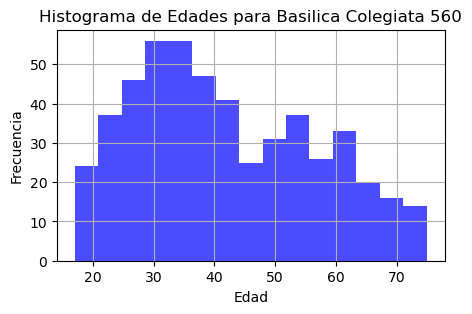

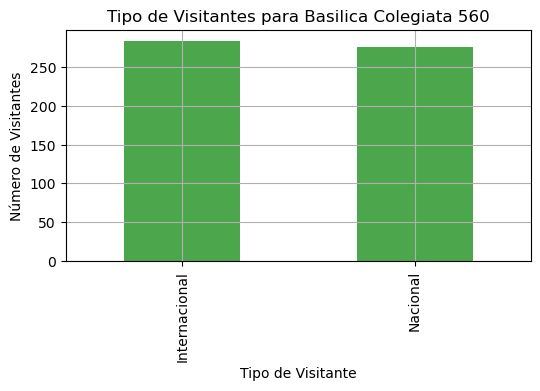

Promedio de sentimiento: 0.13
Desviación estándar de sentimiento: 0.22

Palabras más comunes:
de: 918
la: 751
the: 637
a: 470
y: 431
en: 416
es: 371
el: 324
que: 315
of: 298

---------------
Estadísticas para: Mercado Hidalgo 600

Promedio de calificación: 3.95
Desviación estándar: 0.95

Promedio de longitud de opiniones: 53.68
Desviación estándar de longitud de opiniones: 38.05



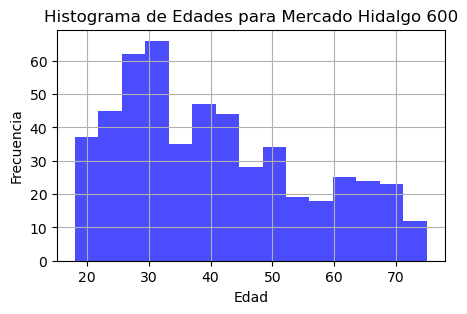

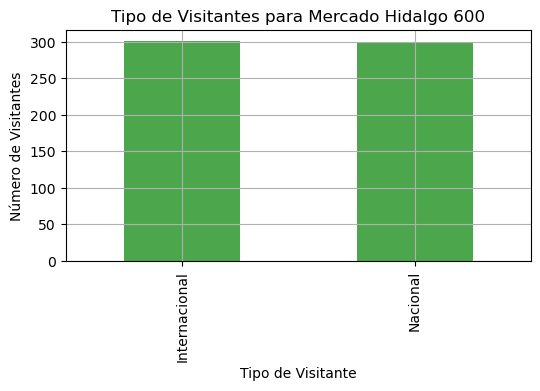

Promedio de sentimiento: 0.13
Desviación estándar de sentimiento: 0.22

Palabras más comunes:
de: 914
the: 621
a: 593
y: 568
la: 478
and: 411
que: 398
es: 389
en: 384
el: 320

---------------
Estadísticas para: Casa de Diego Rivera 698

Promedio de calificación: 4.24
Desviación estándar: 0.80

Promedio de longitud de opiniones: 56.77
Desviación estándar de longitud de opiniones: 33.55



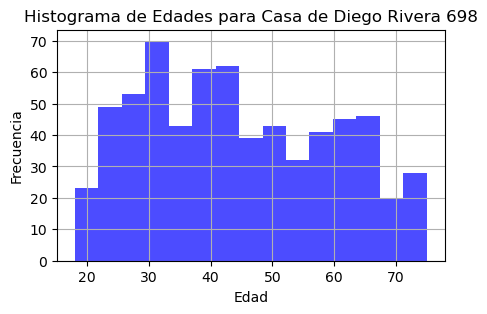

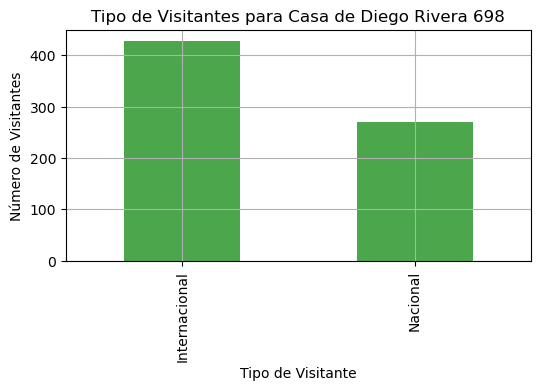

Promedio de sentimiento: 0.14
Desviación estándar de sentimiento: 0.19

Palabras más comunes:
de: 1135
the: 1032
of: 733
la: 705
a: 695
and: 572
diego: 537
rivera: 500
y: 495
que: 457

---------------
Estadísticas para: Universidad de Guanajuato 900

Promedio de calificación: 4.60
Desviación estándar: 0.61

Promedio de longitud de opiniones: 41.49
Desviación estándar de longitud de opiniones: 22.25



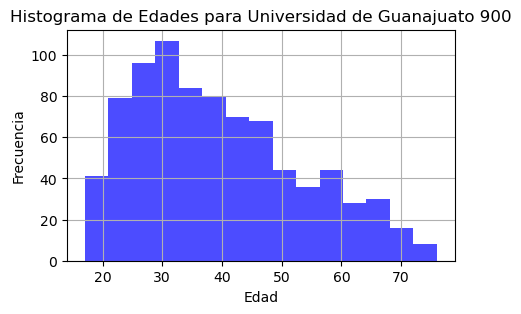

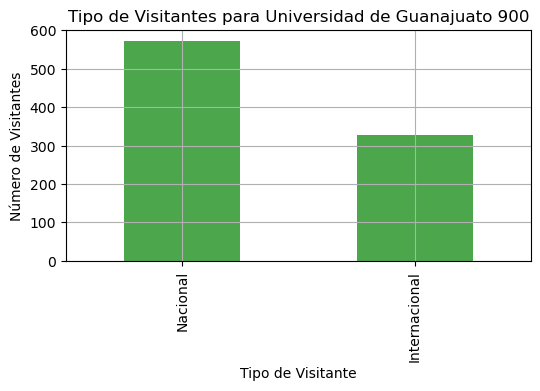

Promedio de sentimiento: 0.11
Desviación estándar de sentimiento: 0.23

Palabras más comunes:
de: 1539
la: 1302
y: 741
que: 684
es: 663
a: 605
the: 555
en: 521
el: 454
una: 448

---------------
Estadísticas para: Alhóndiga 930

Promedio de calificación: 4.45
Desviación estándar: 0.75

Promedio de longitud de opiniones: 53.59
Desviación estándar de longitud de opiniones: 37.36



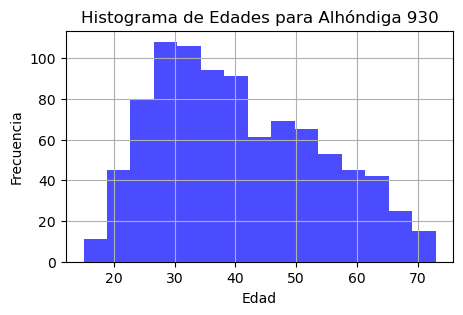

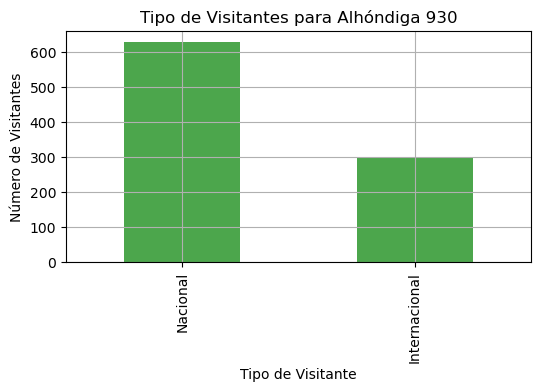

Promedio de sentimiento: 0.07
Desviación estándar de sentimiento: 0.16

Palabras más comunes:
de: 1924
la: 1430
the: 1121
que: 973
y: 821
a: 777
en: 673
es: 662
el: 635
un: 540

---------------
Estadísticas para: Teatro Juárez 1,010

Promedio de calificación: 4.70
Desviación estándar: 0.52

Promedio de longitud de opiniones: 48.47
Desviación estándar de longitud de opiniones: 29.93



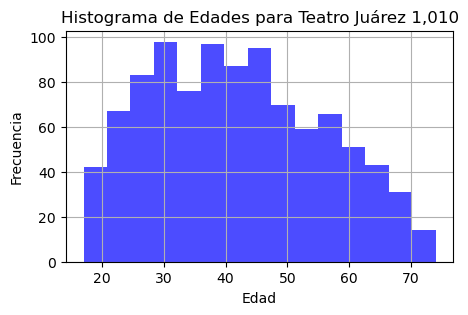

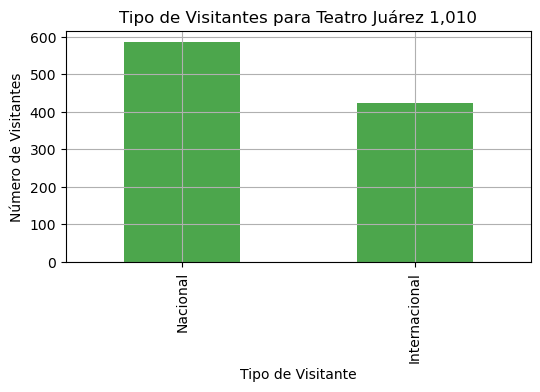

Promedio de sentimiento: 0.11
Desviación estándar de sentimiento: 0.20

Palabras más comunes:
de: 1602
la: 1141
y: 913
the: 906
a: 892
que: 792
el: 786
es: 758
en: 706
teatro: 514

---------------
Estadísticas para: Jardín de la Unión 1,134

Promedio de calificación: 4.59
Desviación estándar: 0.61

Promedio de longitud de opiniones: 50.84
Desviación estándar de longitud de opiniones: 41.72



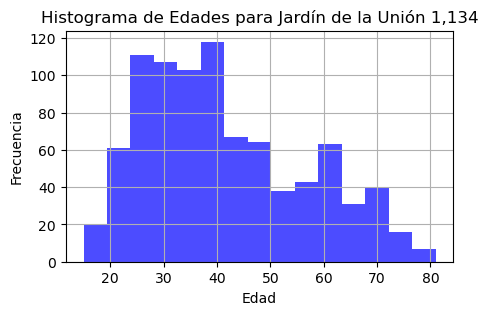

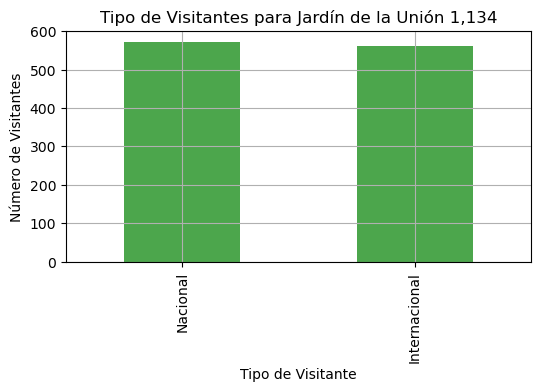

Promedio de sentimiento: 0.17
Desviación estándar de sentimiento: 0.25

Palabras más comunes:
de: 1682
the: 1443
a: 1177
y: 1080
la: 956
and: 921
el: 722
en: 703
of: 618
to: 574

---------------
Estadísticas para: Callejón del Beso 1,360

Promedio de calificación: 4.00
Desviación estándar: 0.97

Promedio de longitud de opiniones: 52.45
Desviación estándar de longitud de opiniones: 36.60



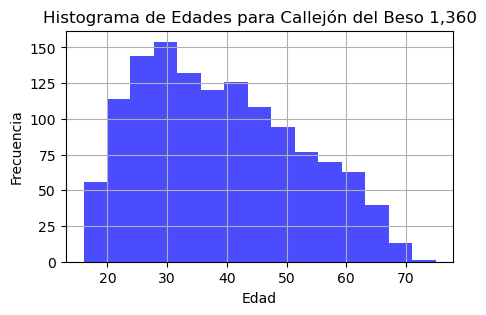

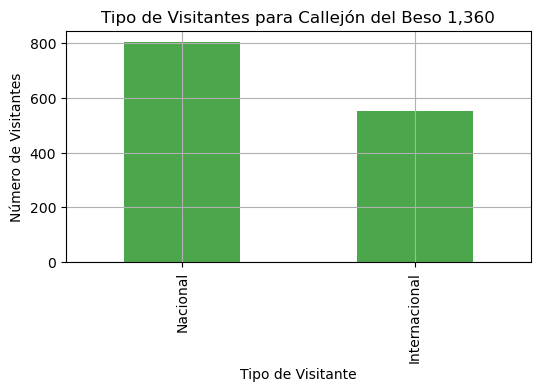

Promedio de sentimiento: 0.06
Desviación estándar de sentimiento: 0.16

Palabras más comunes:
de: 1978
la: 1801
que: 1657
y: 1474
a: 1360
es: 1171
el: 1076
en: 1054
the: 937
un: 845

---------------
Estadísticas para: Monumento Pípila 1,620

Promedio de calificación: 4.38
Desviación estándar: 0.77

Promedio de longitud de opiniones: 54.80
Desviación estándar de longitud de opiniones: 40.15



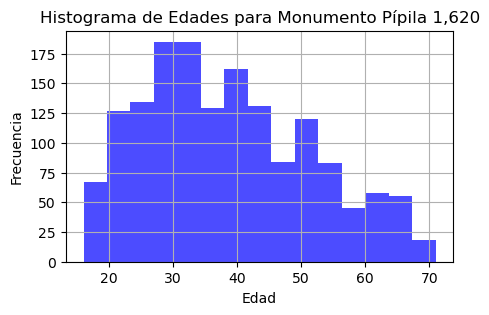

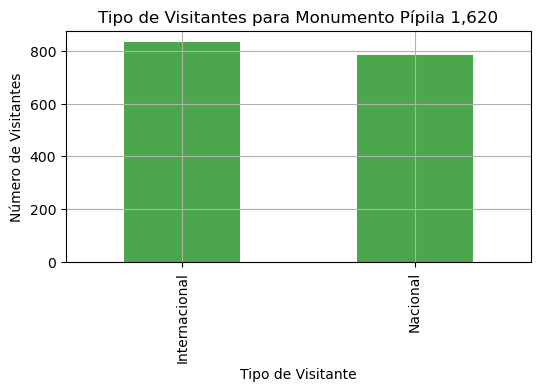

Promedio de sentimiento: 0.11
Desviación estándar de sentimiento: 0.22

Palabras más comunes:
la: 2854
de: 2815
the: 2426
el: 1517
a: 1488
que: 1411
y: 1339
es: 1320
en: 1034
ciudad: 879

---------------
Estadísticas para: Museo de las Momias 1,650

Promedio de calificación: 3.68
Desviación estándar: 1.14

Promedio de longitud de opiniones: 67.15
Desviación estándar de longitud de opiniones: 51.98



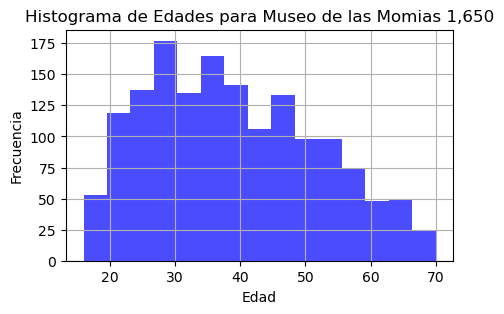

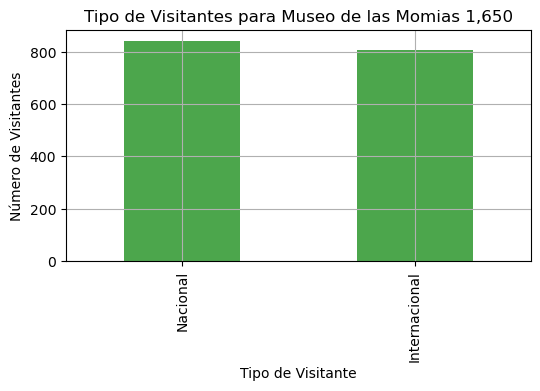

Promedio de sentimiento: 0.04
Desviación estándar de sentimiento: 0.17

Palabras más comunes:
de: 2833
que: 2273
the: 2027
a: 1923
la: 1747
y: 1734
es: 1483
el: 1408
en: 1347
no: 1314

---------------


In [64]:
# Iteramos sobre cada lugar y su DataFrame en el diccionario
for lugar, df in dfs.items():
    print(f"Estadísticas para: {lugar}")
    print()
    PromDesDF(df)
    PromOpDF(df)
    PlotEdad(df, lugar)
    PlotTipoVisitante(df, lugar)
    SentimentAnalysis(df)
    WordFrequency(df)

    print("---------------")

**Discusión**

Las calificaciones de los lugares en una escala del 1 al 5 oscilan entre 3.68 y 4.70, siendo calificaciones en su mayoría positivas. La calificación mas baja se la llevo el *museo de las momias* y la calificación mas alta la tiene el *teatro juarez*, aunque la desviación estándar del museo de las momias es la mas alta de todas, por lo que la calificación baja se puede deber a unas pocas opiniones que se salieron de la media que no les gusto el teatro. 

En cuanto a la distribución de las edades, en su mayoría los lugares fueron visitados por personas entre 20 y 40 años, siendo el grupo mas numeroso personas de 30 años. Los lugares con mas presencia de personas jóvenes (20 - 30 años) fueron por supuesto *la universidad de Guanajuato*, *el jardín de la unión* y el *mercado hidalgo* mientras que los lugares con una distribución mas uniforme de las edades fueron *el teatro Juarez* y *la casa Diego Rivera*.

Se tienen en la mayoría de lugares la misma presencia de opiniones nacionales e internacionales, destacando que en los lugares donde esto no pasa, las opiniones que son mayoría son las nacionales.

Para los análisis complementarios se propone un análisis de sentimientos simple utilizando la librería **TextBlob** la cual utiliza por defecto un clasificador entrenado con un modelo de Naive Bayes sobre un dataset de reseñas de películas.

TextBlob evalúa dos propiedades en el análisis de sentimientos:

* Polarity: Un valor flotante dentro del rango [-1.0, 1.0] donde -1.0 indica un sentimiento negativo y 1.0 indica un sentimiento positivo.
* Subjectivity: Un valor flotante dentro del rango [0.0, 1.0] donde 0.0 es muy objetivo y 1.0 es muy subjetivo.

En este caso solo medimos la medía y desviación estándar de la **polaridad** de los sentimientos. Por lo que los valores oscilan entre [-1, 1]. En su mayoría el análisis de sentimientos tiende a ser positivo, aunque la gran mayoría no pasa del valor 0.15, por lo que según el análisis las opiniones tienden a ser neutras. Esto en contraste con la calificación sugiere que las personas tienden a utilizar un lenguaje neutral en sus opiniones, aunque cuando se califica usan valores altos positivos, ya que los scores son muy positivos, mientras que las opiniones son muy neutras. Interesante de ver :o 

Sería interesante comparar este score entre nacionales e internacionales, tal vez la forma de escribir cambia.

El último análisis complementario es uno de palabras mas comunes, donde en su mayoría coincidió que fueron stopwords, como artículos. En el caso de la casa Diego Rivera fue mucho el uso de las palabras "Rivera" y "Diego" obvio por el titulo del lugar, aunque es interesante que el único lugar donde se mencionó el nombre dentro de las palabras mas comunes.

**2. Utilizando una estrategia de feature selection (se sugiere $\chi^2$ o ganancia de información) visualice con [word_cloud](https://amueller.github.io/word_cloud/) nubes de palabras el top k (se sugiere 50) de palabras más relevantes para cada uno de los 10 lugares. Note que serán 10 nubes, una por lugar.**

Para realizar esto, necesitamos implementar una función que realicé el test de $\chi^2$ y nos de las palabras mas frecuentes para graficar los resultados en una nube de palabras. 

In [223]:
def chiSquare(dataframe):

    sw = stopwords.words('spanish') 

    vectorizer = TfidfVectorizer(stop_words=sw)
    X = vectorizer.fit_transform(dataframe['Opinión'])

    # Usar y como etiquetas binarias para opiniones negativas
    y = (dataframe['Escala'])

    # Selección de características usando chi2
    selector = SelectKBest(chi2, k=50)
    X_new = selector.fit_transform(X, y)

    # Obtener las características seleccionadas
    feature_names = np.array(vectorizer.get_feature_names_out())
    selected_features = feature_names[selector.get_support()]

    # Crear y mostrar la nube de palabras
    word_freq = dict(zip(selected_features, np.asarray(X_new.sum(axis=0)).ravel()))
    return word_freq

Gráfica para: Basilica Colegiata 560


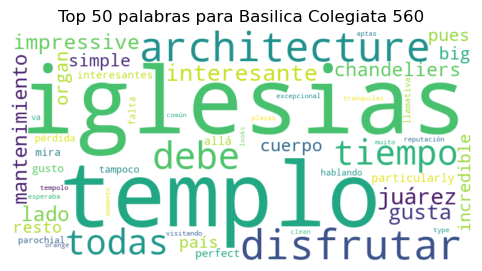

---------------
Gráfica para: Mercado Hidalgo 600


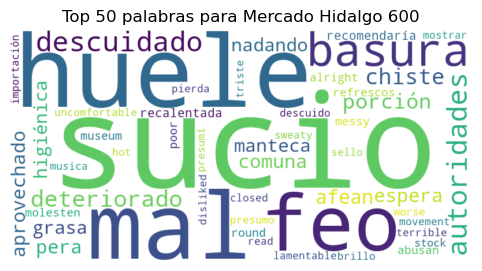

---------------
Gráfica para: Casa de Diego Rivera 698


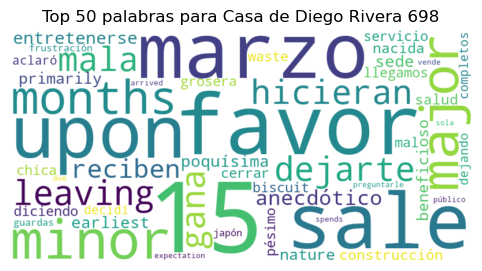

---------------
Gráfica para: Universidad de Guanajuato 900


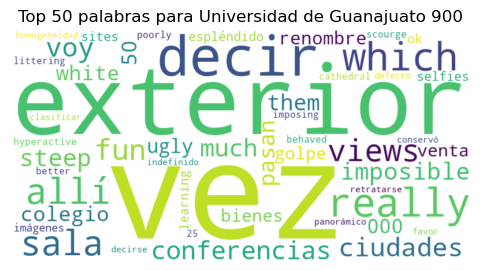

---------------
Gráfica para: Alhóndiga 930


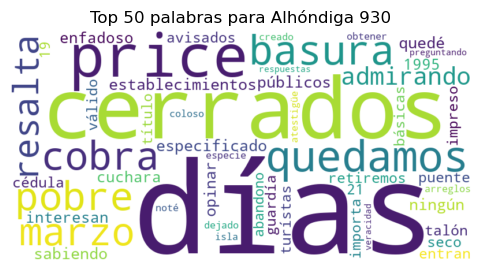

---------------
Gráfica para: Teatro Juárez 1,010


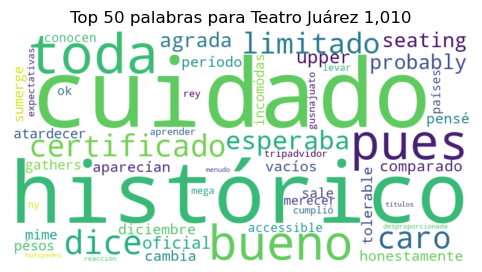

---------------
Gráfica para: Jardín de la Unión 1,134


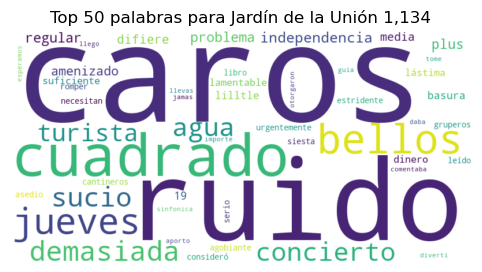

---------------
Gráfica para: Callejón del Beso 1,360


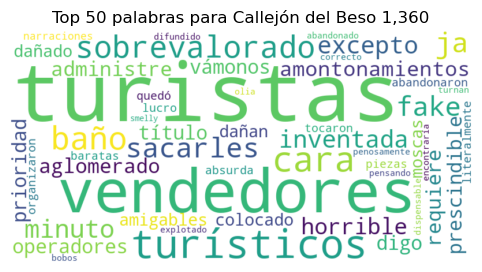

---------------
Gráfica para: Monumento Pípila 1,620


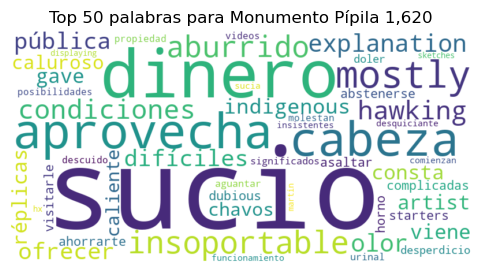

---------------
Gráfica para: Museo de las Momias 1,650


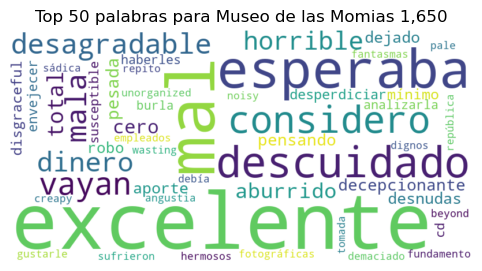

---------------


In [224]:
# Iteramos sobre cada lugar y su DataFrame en el diccionario
for lugar, df in dfs.items():
    print(f"Gráfica para: {lugar}")

    # Llamamos a la función
    word_freq = chiSquare(df)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(8, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Top 50 palabras para {lugar}')
    plt.axis("off")
    plt.show()

    print("---------------")

**Discusión**

Vemos palabras asociadas con los lugares, tanto en inglés como en español. Por ejemplo en el monumento del pipila, una palabra es *caluroso* lo cual es indicativo de como se tiene que subir para llegar ahí, en medio del calor. O en el teatro Juarez que se resalta la arquitectura y lo cuidado que esta el edificio. La gran mayoría reflejan en las palabras mas probables características negativas de los lugres, por ejemplo en el mercado Hidalgo y en el monumento al pipila, *sucio*. Definitivamente se puede saber muchísimo con este tipo de análisis. 

**3. Para cada uno de los 10 sitios turísticos, haga un descubrimiento automático de los 3 tópicos con LSA (investiga, estudia y aprende por su cuenta LSA) más relevantes y 10 palabras contenidas en cada tópico de cada uno de los siguientes subgrupos:**

* (a) Hombres
* (b) Mujeres
* (c) Turistas Nacionales
* (d) Turistas Internacionales
* (e) Jovénes (elige un rango de edad interesante con base en sus estadísticas)
* (f) Mayores (elige un rango de edad interesante con base en sus estadísticas)

Para realizar el análisis de tópicos necesitamos aplicar el análisis semántico latente, es decir aplicar una descomposición tipo SVD a una matriz tipo *término-documento* como una bow. Necesitamos entonces construir una matriz bow, (función que ya tenemos), sin embargo voy a utilizar la librería scikit para este fin ya que nunca la he utilizado para construir una matriz bow. Utilizamos *TfidfVectorizer* de scikit-learn para convertir los textos limpios a una matriz TF-IDF que será tu entrada para LSA. Como en el ejercicio anterior, realizamos las funciones para al final solo aplicar un ciclo for que haga esto para todos los lugares.

In [140]:
# Función para construir una matriz tipo tfidf
def LSAforDF(dataframe, genero, n_components):
    
    # Subgrupo de genero
    subgrupo = dataframe[dataframe['Género'] == genero]

    # Configuración de stopwords
    spanish_stopwords = stopwords.words('spanish')

    # Inicializar el vectorizador TFIDF
    vectorizer = TfidfVectorizer(stop_words=spanish_stopwords)

    # Construir matriz TFIDF
    X = vectorizer.fit_transform(subgrupo['Opinión'])

    # Aplicar LSA
    svd_model = TruncatedSVD(n_components=n_components, random_state=42)
    lsa_matrix = svd_model.fit_transform(X)

    # Identificar tópicos y palabras clave
    terms = vectorizer.get_feature_names_out()
    for i, comp in enumerate(svd_model.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:10]
        print("Tópico " + str(i+1) + ": ")
        print([term for term, _ in sorted_terms])

In [144]:
# Iteramos sobre cada lugar y su DataFrame en el diccionario
for lugar, df in dfs.items():
    print(f"Estadísticas para: {lugar}")
    
    # Análisis de LSA
    print("LSA para el género masculino")
    LSAforDF(df, genero = "Masculino", n_components=2)

    print()

    print("LSA para el género femenino")
    LSAforDF(df, genero = "Femenino", n_components=2)

    print("---------------")

Estadísticas para: Basilica Colegiata 560
LSA para el género masculino
Tópico 1: 
['the', 'of', 'and', 'is', 'in', 'it', 'to', 'this', 'you', 'church']
Tópico 2: 
['ciudad', 'guanajuato', 'iglesia', 'noche', 'centro', 'lugar', 'hermosa', 'basílica', 'bonita', 'visitar']

LSA para el género femenino
Tópico 1: 
['the', 'and', 'of', 'is', 'in', 'to', 'it', 'beautiful', 'this', 'you']
Tópico 2: 
['ciudad', 'hermosa', 'iglesia', 'guanajuato', 'basílica', 'centro', 'dentro', 'bonita', 'noche', 'arquitectura']
---------------
Estadísticas para: Mercado Hidalgo 600
LSA para el género masculino
Tópico 1: 
['the', 'and', 'of', 'to', 'is', 'you', 'in', 'market', 'it', 'for']
Tópico 2: 
['mercado', 'comida', 'lugar', 'artesanías', 'comprar', 'comer', 'si', 'recuerdos', 'precios', 'variedad']

LSA para el género femenino
Tópico 1: 
['the', 'and', 'to', 'of', 'it', 'is', 'you', 'market', 'food', 'in']
Tópico 2: 
['mercado', 'lugar', 'comida', 'si', 'comprar', 'dulces', 'artesanías', 'comer', 'buen',

**Discusión**

El análisis determina unas conclusiones bastante interesantes según las palabras obtenidas del LSA. Para la Basilica Colegiata los tópicos obtenidos reflejan un enfoque en los elementos arquitectónicos y la ubicación geográfica ('ciudad', 'Guanajuato', 'iglesia'). La mención frecuente de 'noche' podría indicar una preferencia o una recomendación de visitar durante la noche debido a la iluminación o el ambiente. Por lo que si se buscara mejorar las visitas de esta basilica, se podrían incluir tours en la noche, por dar un ejemplo de lo increíble de esto. Otros aspectos importantes pueden ser que a pesar de que tanto hombres como mujeres mencionan aspectos arquitectónicos y la belleza, las mujeres tienden a enfocarse más en detalles estéticos y experiencias sociales como la música y la interacción en lugares como el Jardín de la Unión. En el Mercado Hidalgo y la Alhóndiga, ambos géneros resaltan la importancia culinaria y cultural, aunque las mujeres muestran un interés particular en productos específicos como dulces. 

**4. Para cada uno de los 10 sitios turísticos, haga una nube de palabras que muestre las palabras más asociadas a sus opiniones negativas utilizando $\chi^2$. Puede usar funciones de sklearn.**

Para realizar una nube de palabras necesitamos representar los textos en una representación de texto distribuido (DTR). En este caso vamos a realizar una bolsa de palabras binaria como base de la TCOR. Necesitamos obtener el corpus, realizar un vocabulario, un diccionario, y luego aplicar un test chi square para poder implementar la bow. 

Recordando, las opiniones se encuentran en un dataframe, podemos partir de ahí para realizar todo el proceso. Ocupamos realiza una función que extraiga las opiniones, nos de el vocabulario y diccionario según un dataframe de entrada.

In [216]:
# Función para ordenar las frecuencias
def  SortFrecuency(freqdist):
    # List comprenhension
    aux = [(freqdist[key], key) for key in freqdist]
    aux.sort() # Ordena la lista
    aux.reverse() # Cambiar el orden

    return aux

def GetCorpusVocDicc(dataframe):

    # Tomamos los valores de tr_text del dataframe
    tr_text = dataframe["Opinión"]
    
    corpus_palabras = []

    for doc in tr_text:
        corpus_palabras += tokenizer.tokenize(doc)

    fdist = nltk.FreqDist(corpus_palabras)

    # Ordenamos y obtenemos el vocabulario
    voc = SortFrecuency(fdist)
    voc = voc[:4000] # Tomamos un vocabulario de 4 mil

    dict_indices = dict()
    count = 0

    for weight, word in voc:
        dict_indices[word] = count
        count += 1

    return tr_text, voc, dict_indices

Ahora las funciones para generar las bolsas de palabras y la TCOR.

In [218]:
def build_bow_binary(tr_text, vocabulary, dict_indices):
    # Construcción de matriz para la bolsa de palabras
    # En cada fila vemos los documentos que estamos procesando
    # En las columnas el tamaño del vocabulario que estamos creando
    BOW = np.zeros((len(tr_text),len(vocabulary)), dtype = int)

    for idx, tr in enumerate(tr_text):

        # Cada documento tr lo tokenizamos
        fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))

        # Contamos cada palabra
        for word in fdist_doc:
            # Nos aseguramos que las palabras estan en el diccionario final
            if word in dict_indices:
                BOW[idx, dict_indices[word]] = 1 # Esquema de pesado binario

    return BOW

def compute_tcor(TR):
    # Restricciones sobre los subconjuntos de los documentos
    TR_subset_in = TR # Sin condiciones

    # Inicializamos la bolsa de conceptos (término , término)
    # Si partimos de una bolsa de palabras, las dimensiones serán una matriz cuadrada del vocabulario
    DTR = np.zeros((TR_subset_in.shape[1], TR_subset_in.shape[1]), dtype=float)

    len_voc = TR_subset_in.shape[1] # Tamaño del vocabulario total
    
    # Calculamos la co-ocurrencia bruta de cada par de términos en todos los documentos
    for doc in TR:  # Itera sobre cada documento en la matriz TR
        nonzero_terms = np.nonzero(doc)[0]  # Encuentra los índices de los términos no nulos en el documento actual
        
        # Para cada par único de términos no nulos en el documento, incrementa su co-ocurrencia en la matriz TCOR
        for i in range(len(nonzero_terms)):  # Itera sobre los términos no nulos
            for j in range(i + 1, len(nonzero_terms)): 
                term1, term2 = nonzero_terms[i], nonzero_terms[j]  # Indices de los términos
                DTR[term1, term2] += 1  
                DTR[term2, term1] += 1  # Asegura la simetría de la matriz incrementando la co-ocurrencia inversa
    
    # Calcula T_k para cada término, que es el número de términos distintos con los que co-ocurre
    T_k = np.array([(DTR[i] > 0).sum() for i in range(len_voc)])  # Cuenta los términos distintos para cada término i
    
    # Aplica el pesado tff y el factor logarítmico a cada elemento no nulo de la matriz TCOR
    for i in range(len_voc):  # Itera sobre todos los términos
        for j in range(i + 1, len_voc):  
            if DTR[i, j] > 0:  # Solo aplica el cálculo a términos que co-ocurren
                tff = 1 + np.log10(DTR[i, j])  # Calcula tff
                weight = tff * np.log10(len_voc / T_k[i])
                DTR[i, j] = DTR[j, i] = weight  
    
    return DTR  


Para poder graficar necesitamos reducir la matriz utilizando una estrategia de feature selection en este caso $chi^2$ tal como se hizo en la tarea 3. Se implementa una función para que esto sea lo mas sencillo posible, además una función para plotear cada nube de palabras.

In [219]:
# Función que obtiene la matriz reducida
def getReducedMatrix(TCOR, BOW_tr, tr_labels, dict_indices, nWords):

    # Normalizamos
    TCOR_base = preprocessing.normalize(TCOR, norm = 'l2')

    # Obtener las mejores características
    feast = SelectKBest(chi2, k=nWords)
    feast.fit(BOW_tr, tr_labels)
    best = feast.get_support(indices=True)

    # Diccionario invertido
    dict_indices_invertido = {}
    for w in dict_indices:
        dict_indices_invertido[dict_indices[w]] = w

    # Identificamos las palabras objetivo
    target_words = [dict_indices_invertido[index] for index in best]

    # Nos quedamos con TCOR de solo las mejores palabras
    target_matrix = np.array([TCOR_base[dict_indices[word]] for word in target_words])

    # Crea una instancia de TSNE
    tsne = TSNE(n_components=2) 

    # Utiliza fit_transform para reducir la dimensionalidad
    reduced_matrix = tsne.fit_transform(target_matrix)

    return reduced_matrix, target_words

# Función que grafica la nube de palabras
def plotNube(reduced_matrix, target_words):
    # Suprimir advertencias
    warnings.filterwarnings('ignore')

    # Obtenemos límites para graficar
    max_x = np.amax(reduced_matrix, axis=0)[0]
    max_y = np.amax(reduced_matrix, axis=0)[1]

    # Obtenemos stopwords
    sw = set(stopwords.words("spanish"))

    plt.figure(figsize=(40, 40), dpi=100)
    plt.xlim((-max_x, max_x))
    plt.ylim((-max_y, max_y))
    plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], 20, color='black')

    # Ploteamos cada palabra con su etiqueta
    for idx, word in enumerate(target_words):
        x = reduced_matrix[idx, 0]
        y = reduced_matrix[idx, 1]
        if word in sw:
            plt.annotate(word, (x, y), color='red')
        else:
            plt.annotate(word, (x, y), color='black')

    plt.show()

Con estas funciones ya estamos listos para realizar los gráficos de constelación.

Gráfica para: Basilica Colegiata 560


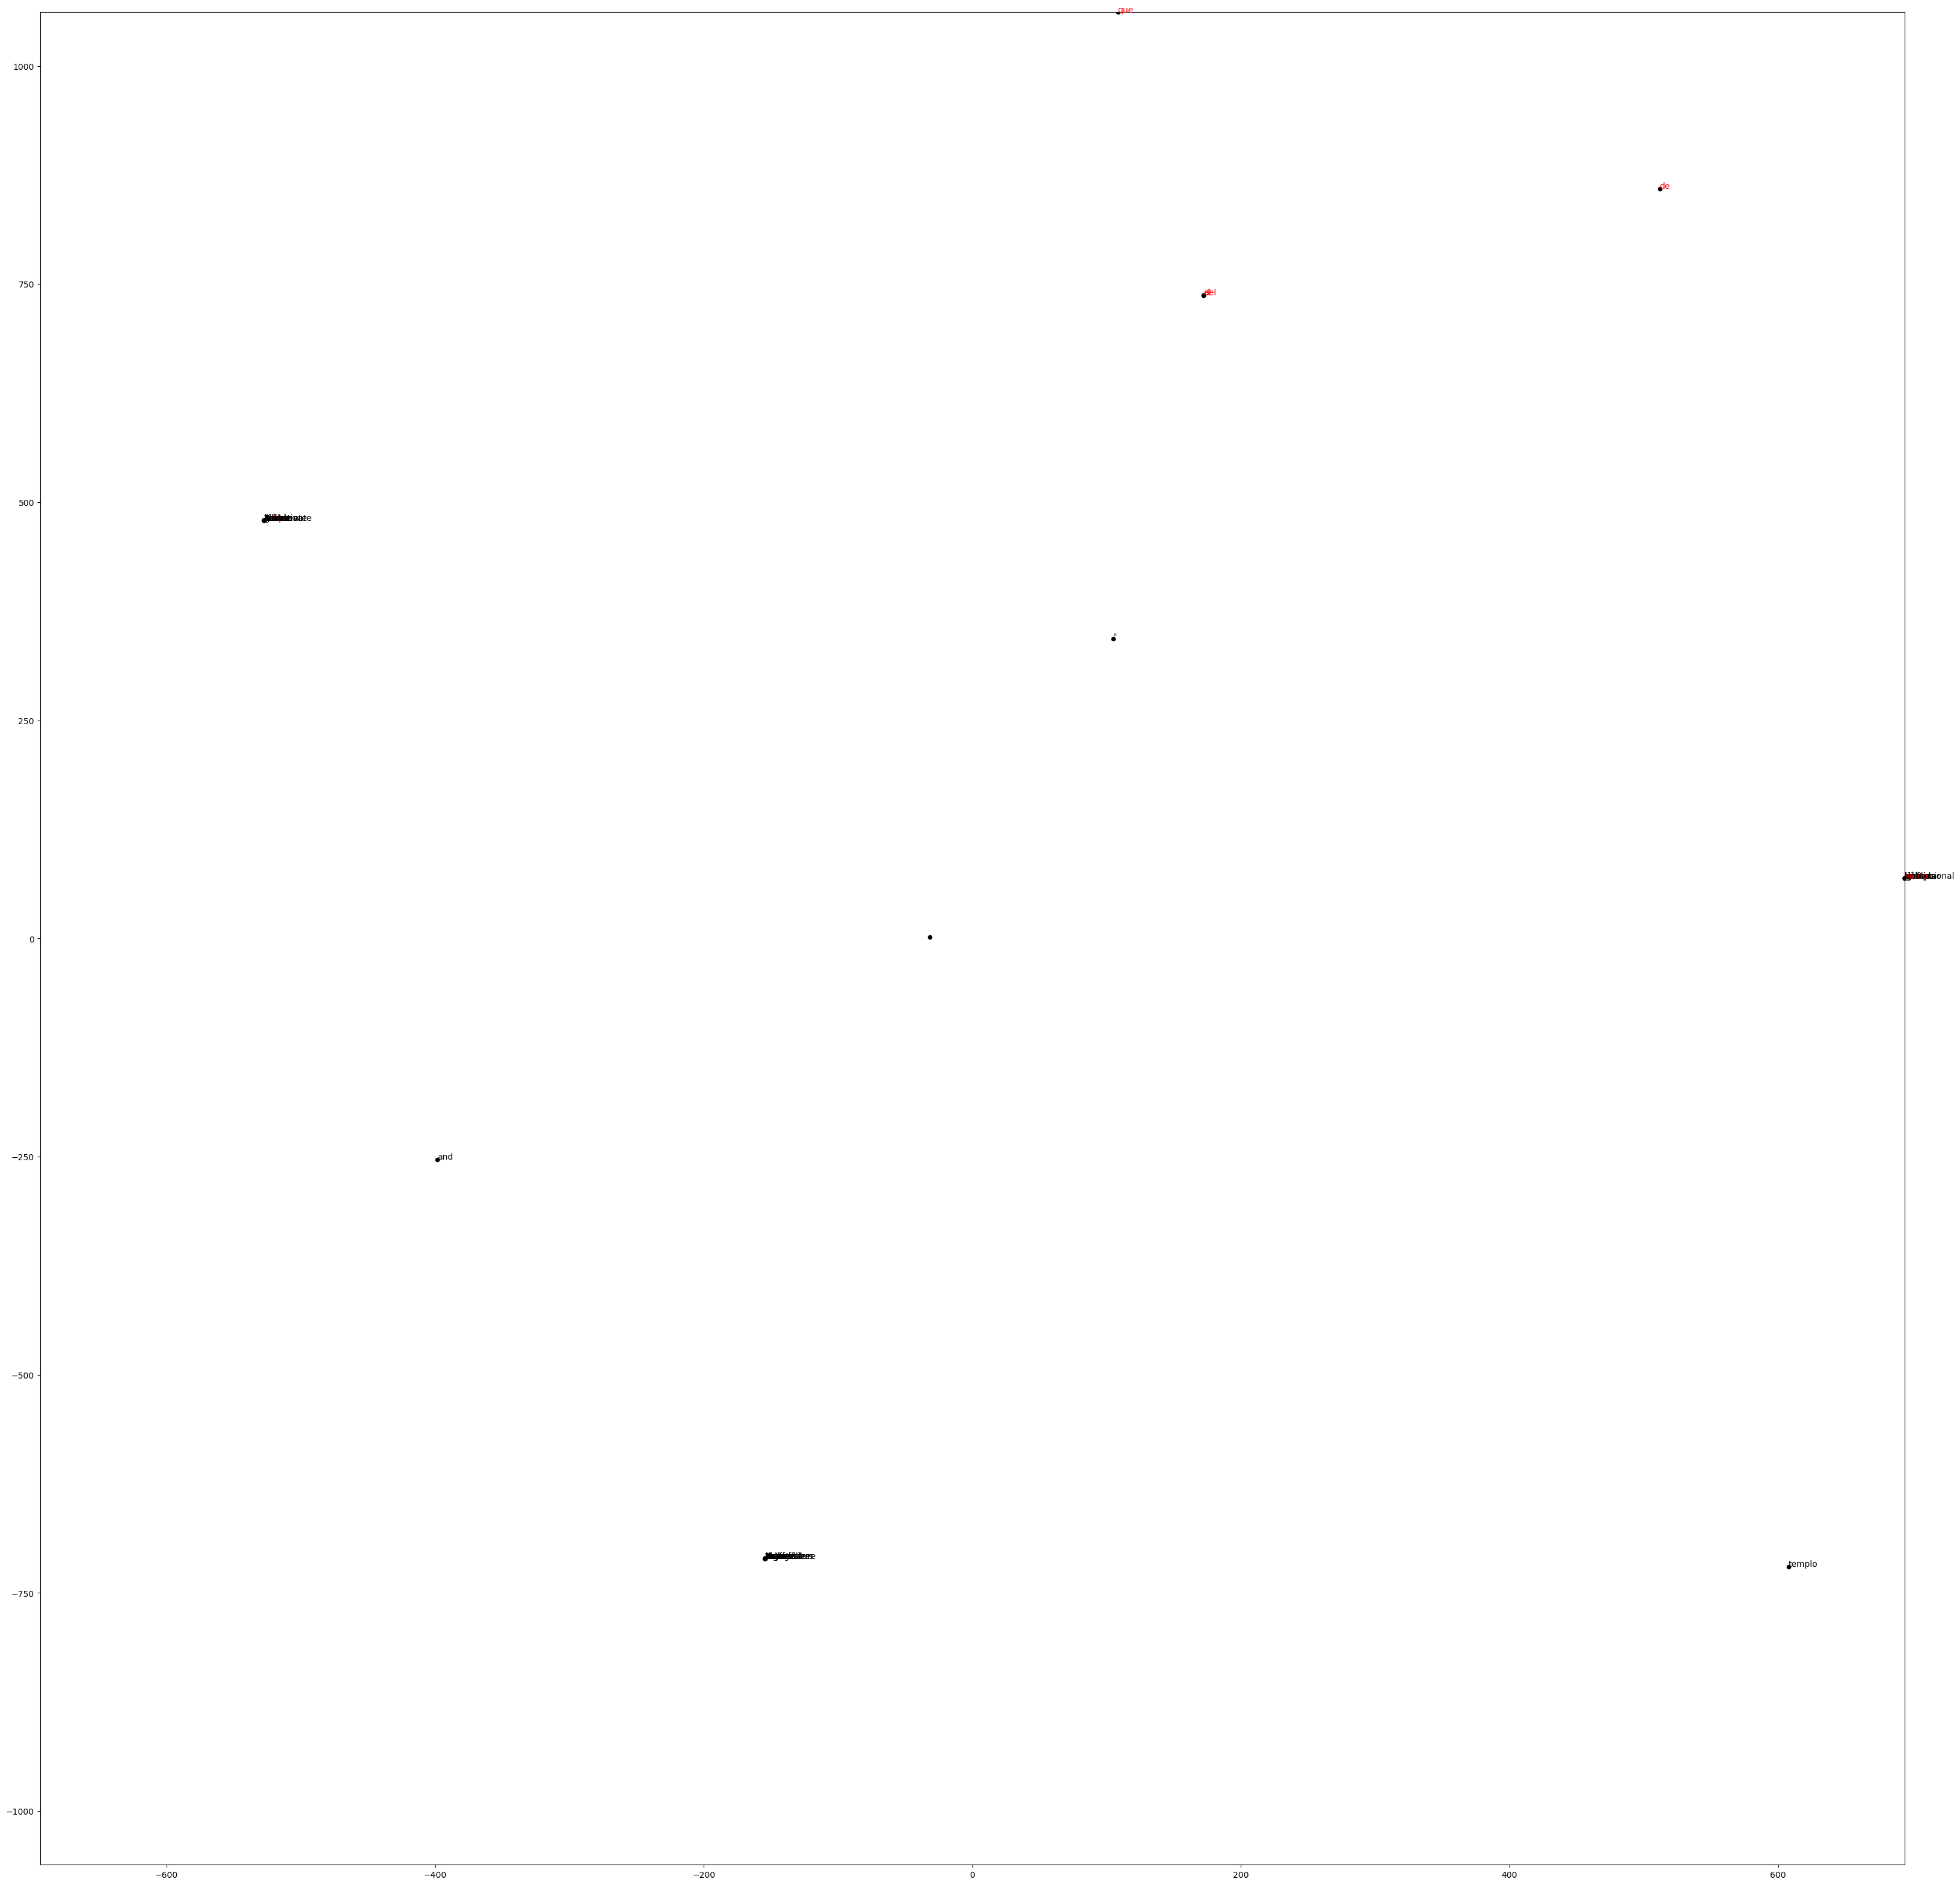

---------------
Gráfica para: Mercado Hidalgo 600


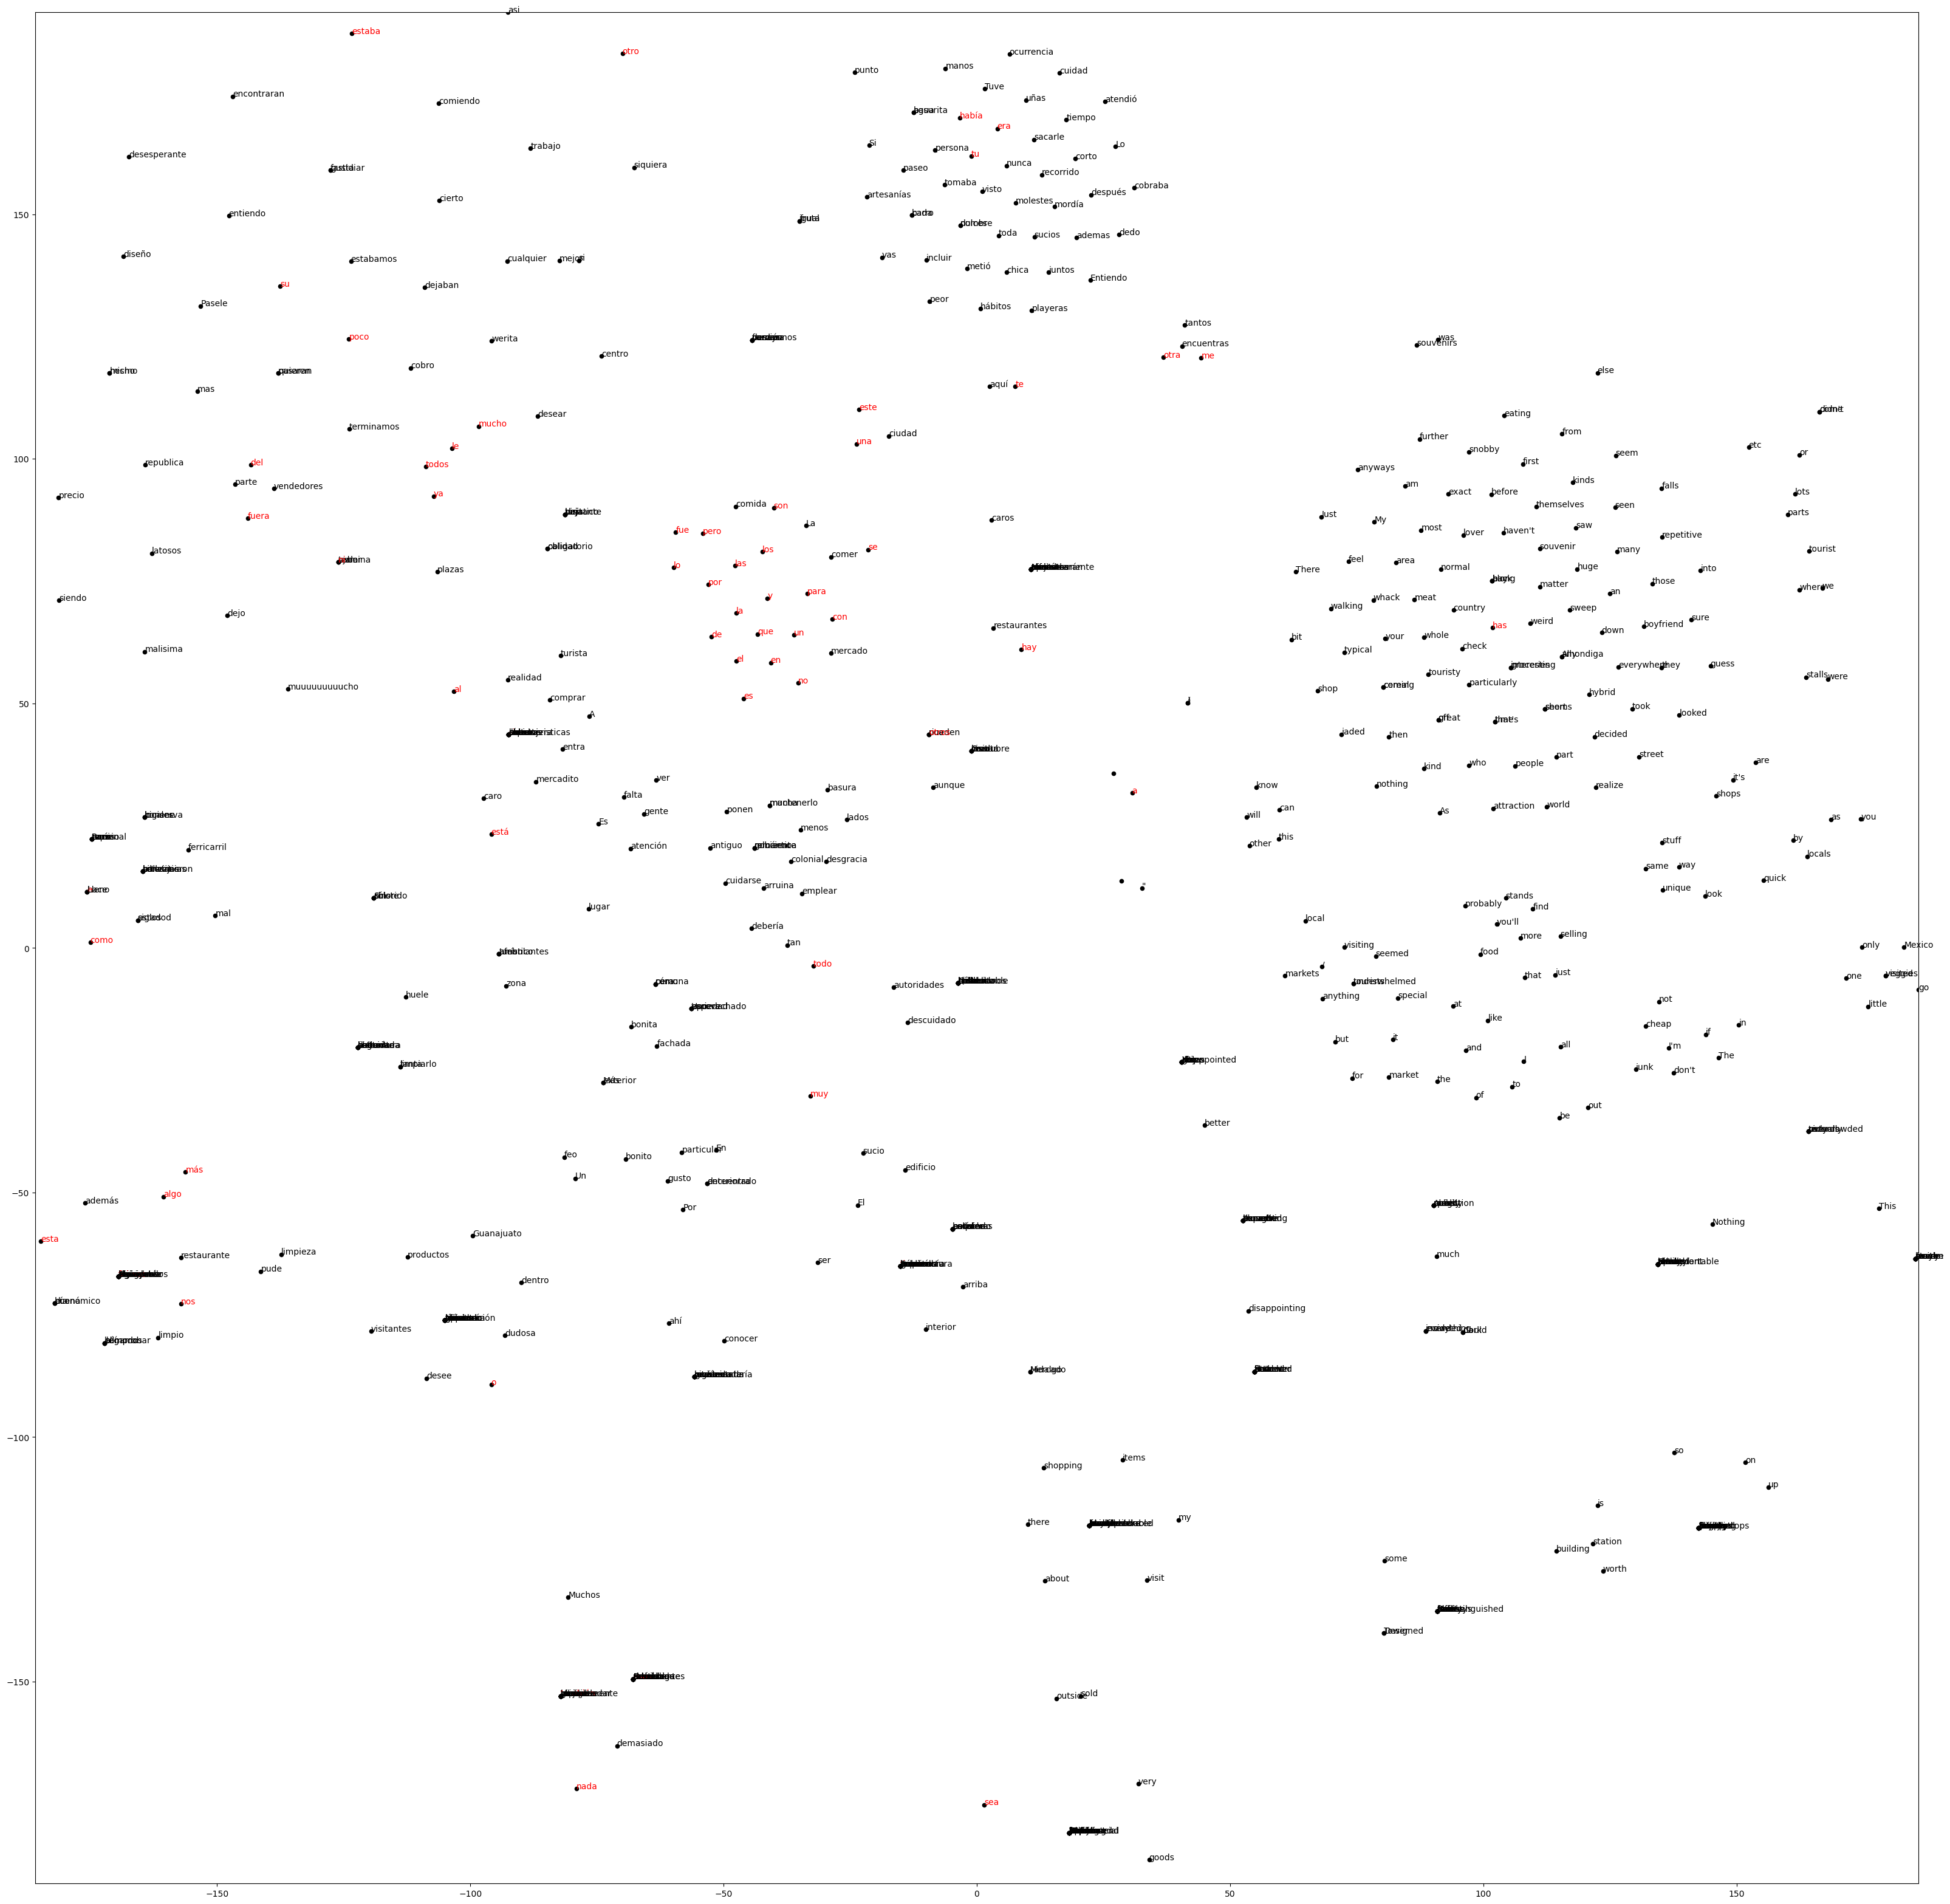

---------------
Gráfica para: Casa de Diego Rivera 698


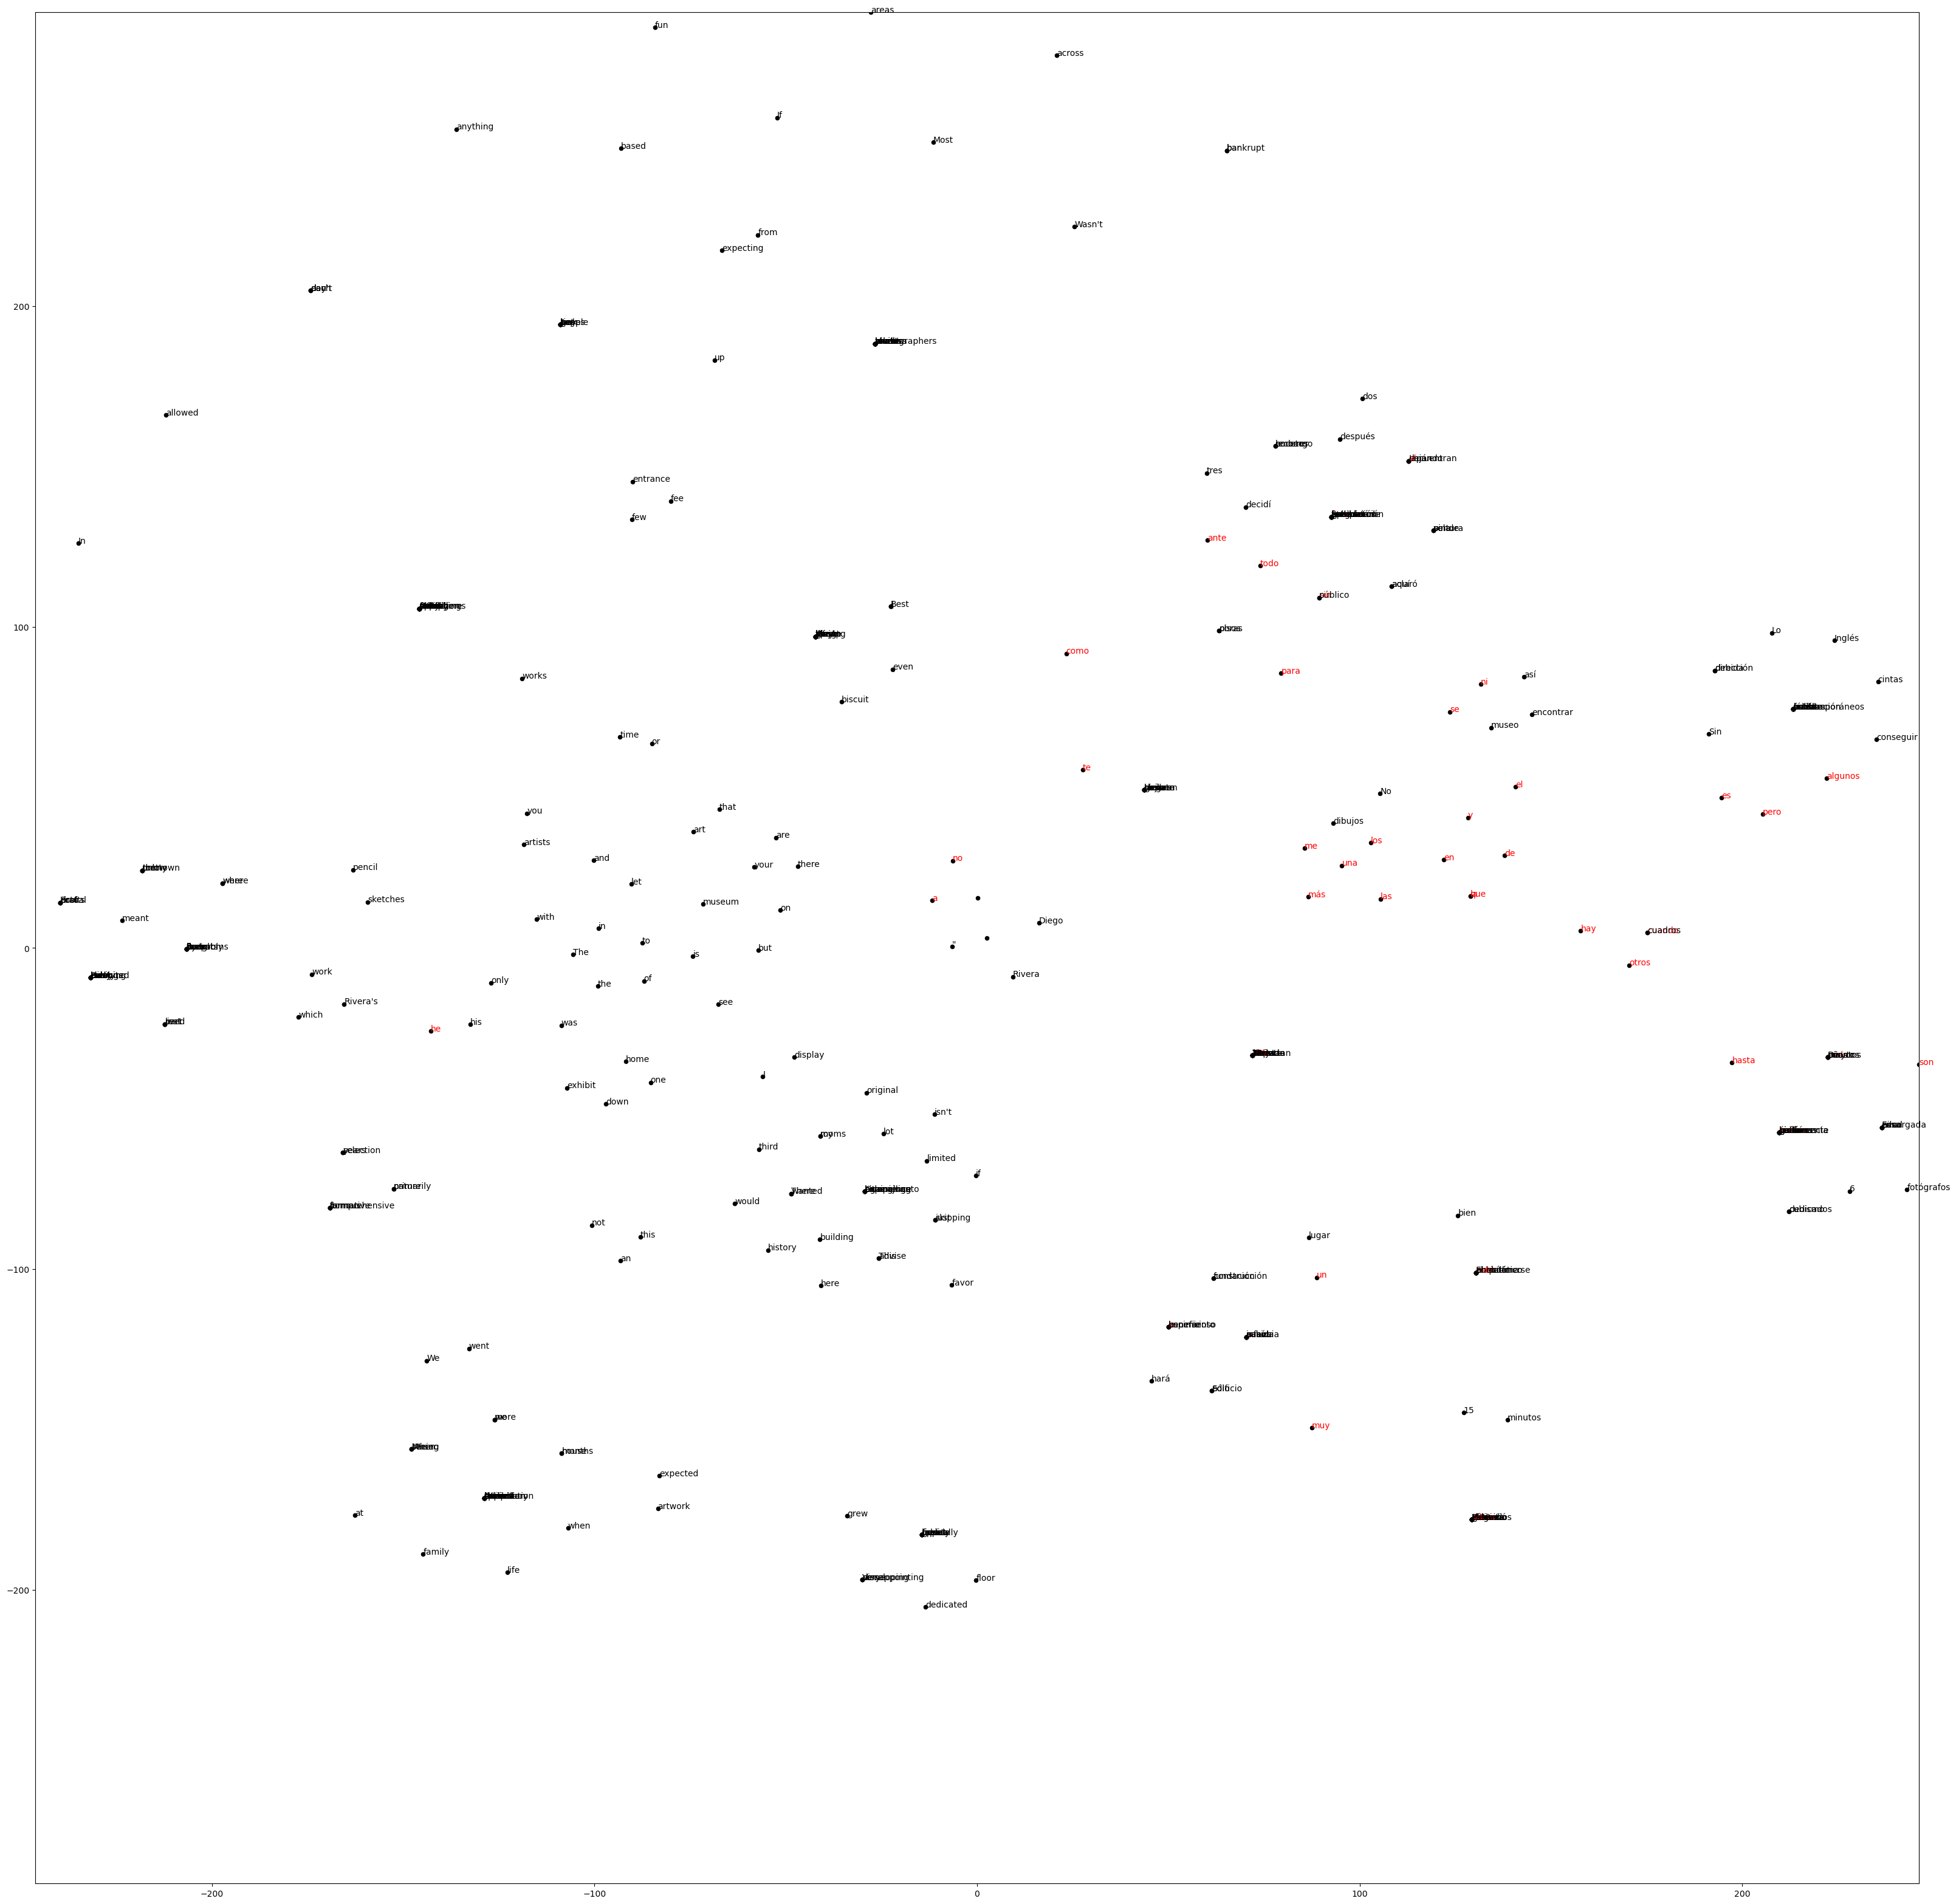

---------------
Gráfica para: Universidad de Guanajuato 900


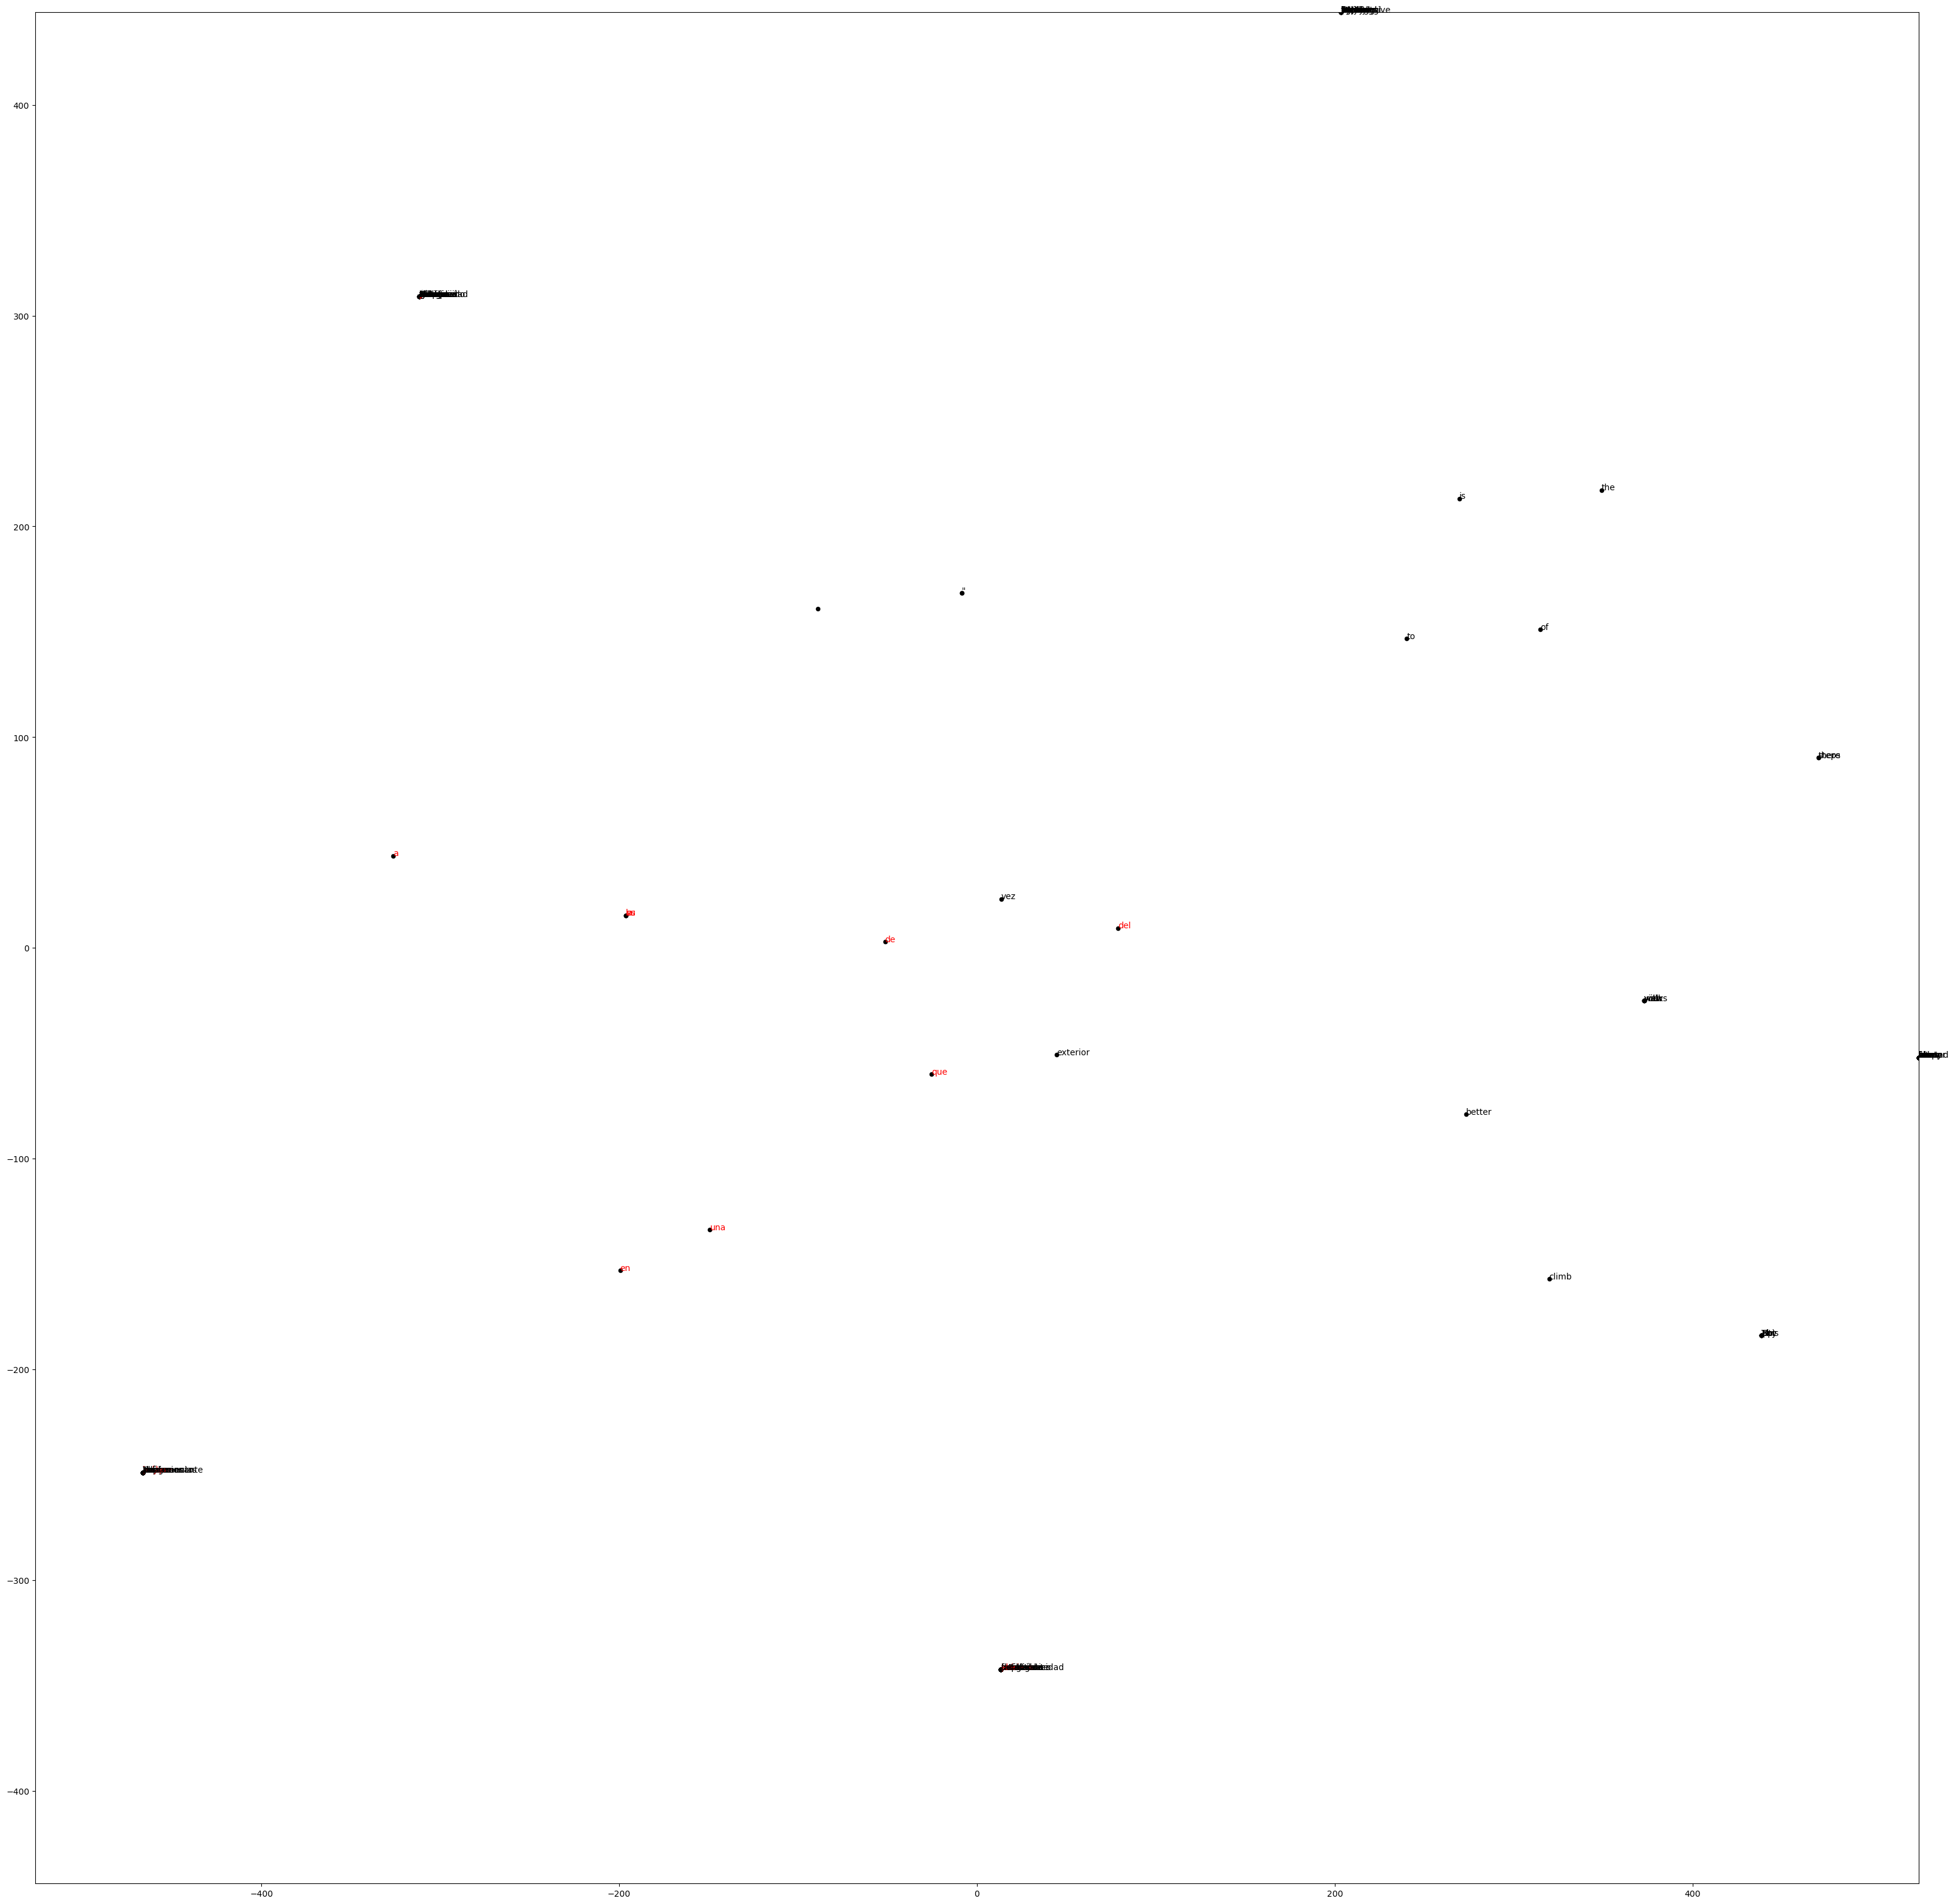

---------------
Gráfica para: Alhóndiga 930


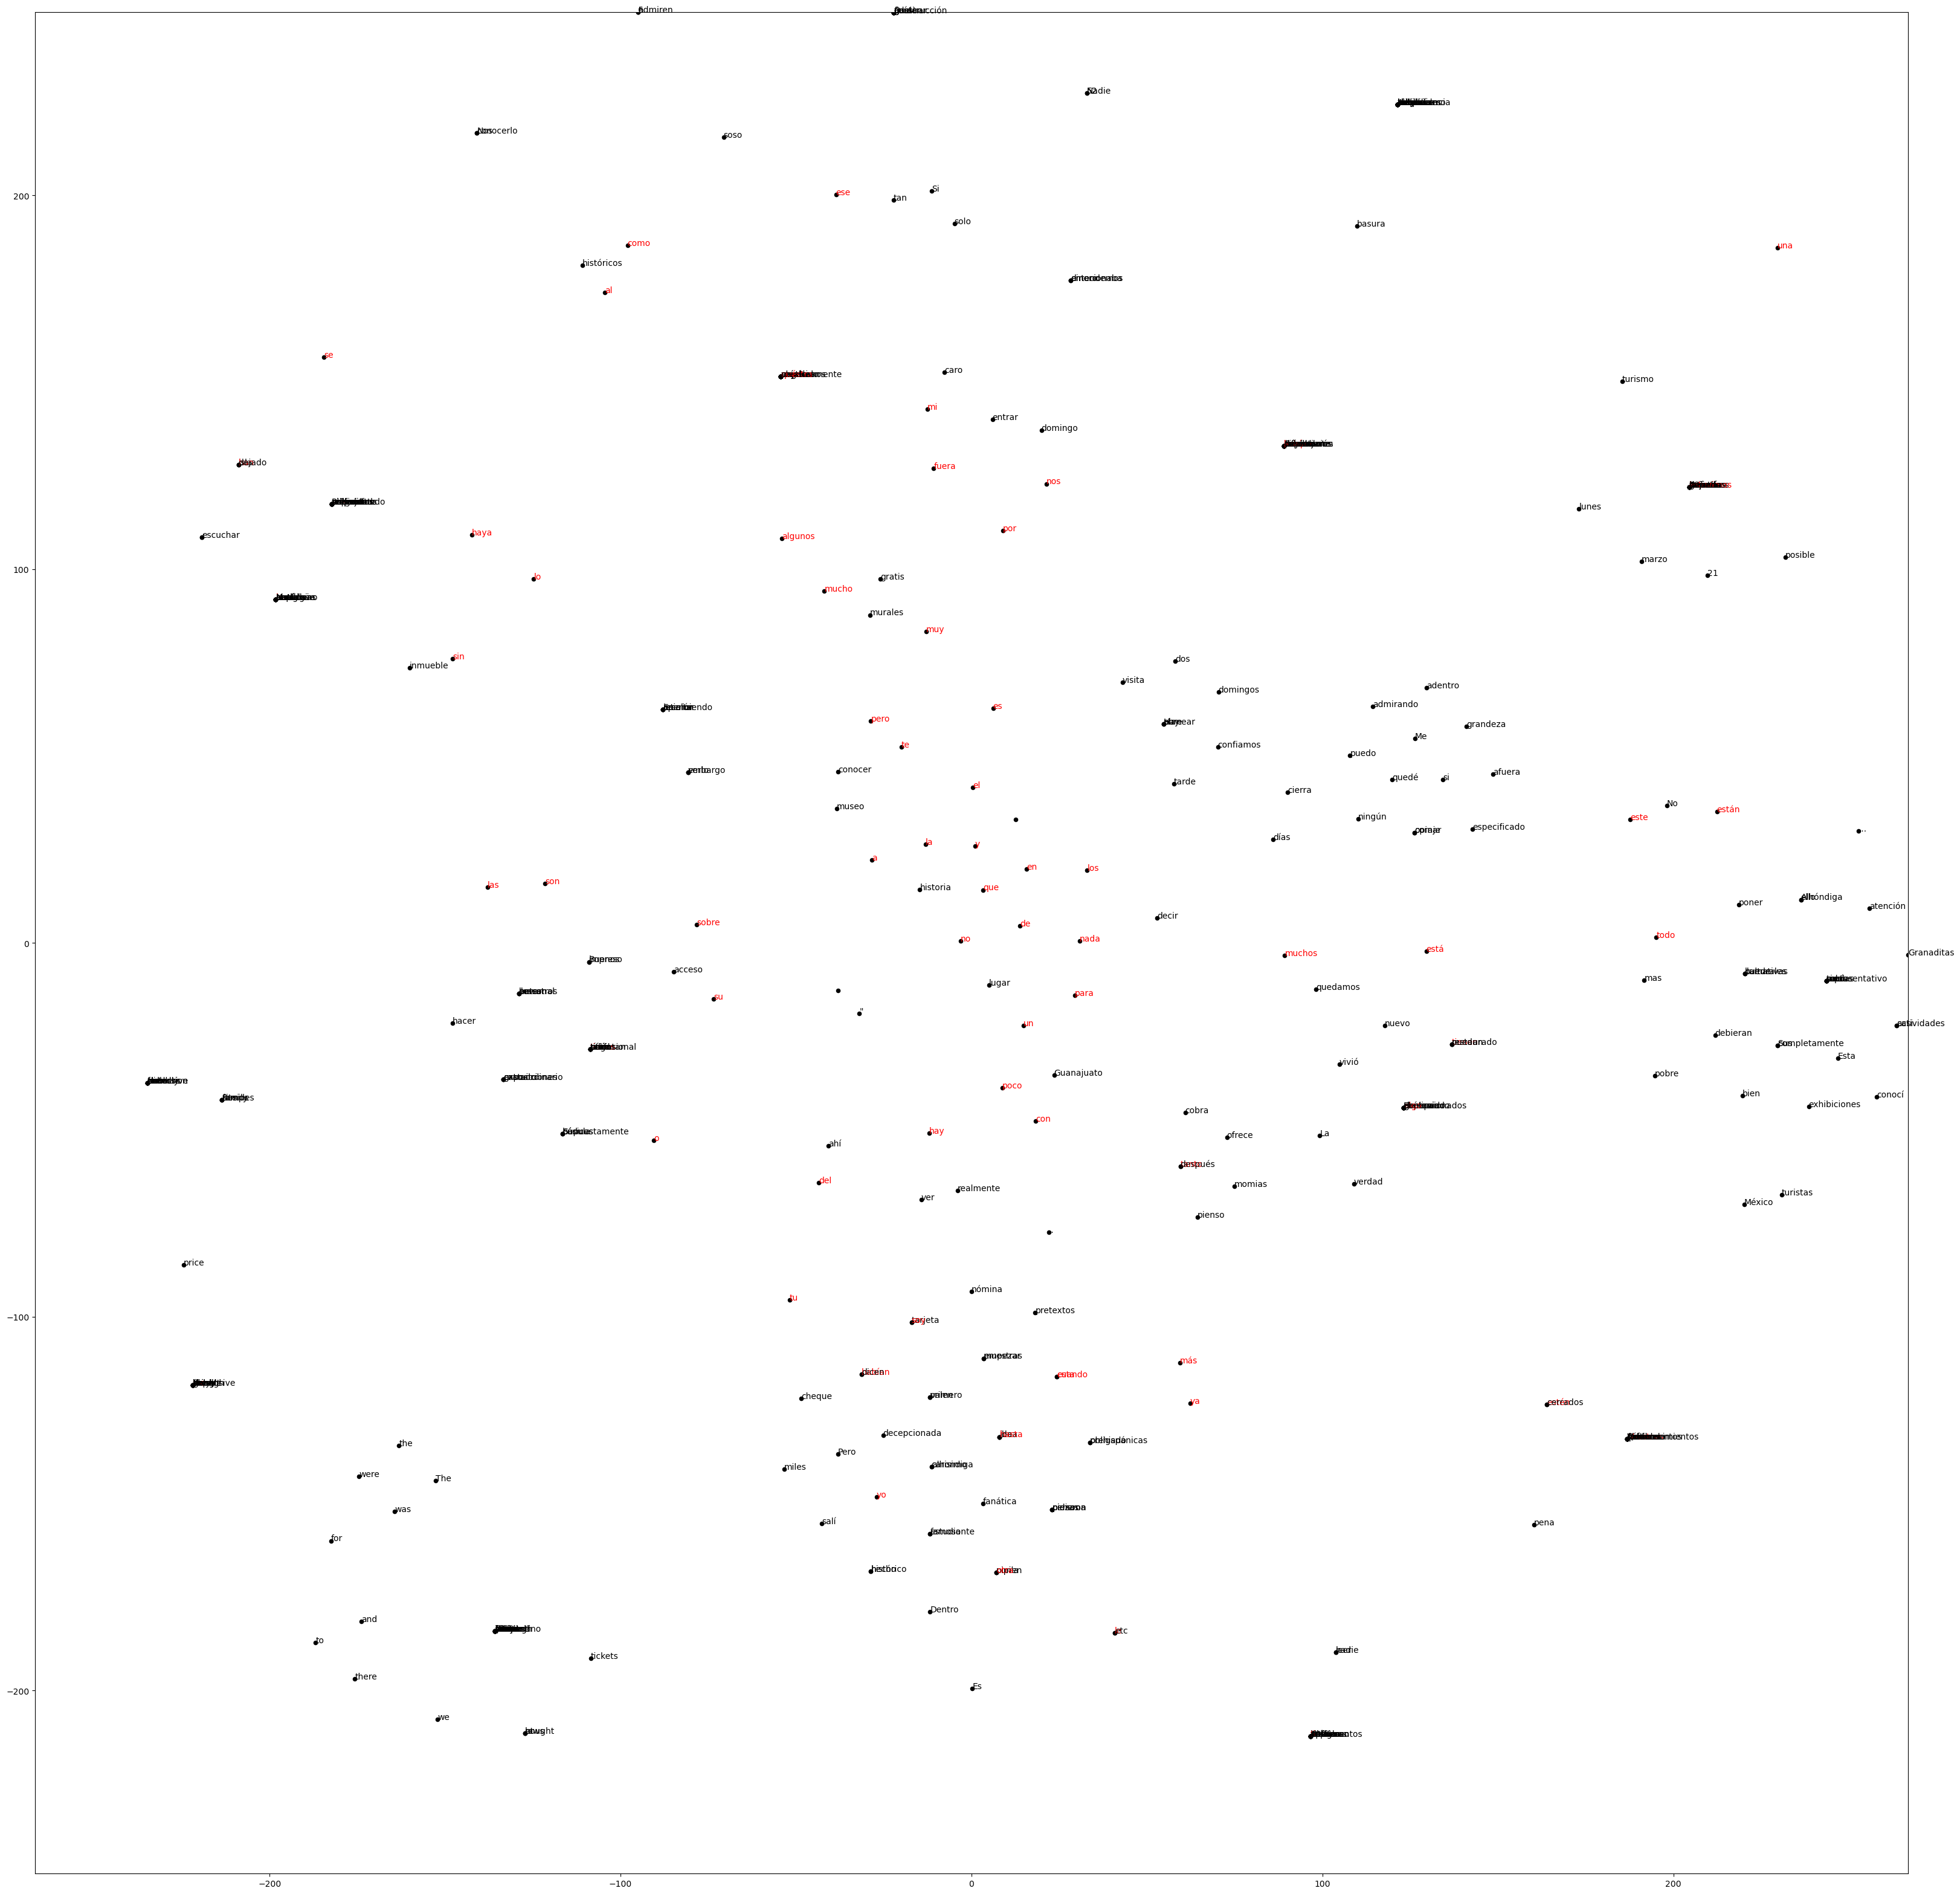

---------------
Gráfica para: Teatro Juárez 1,010


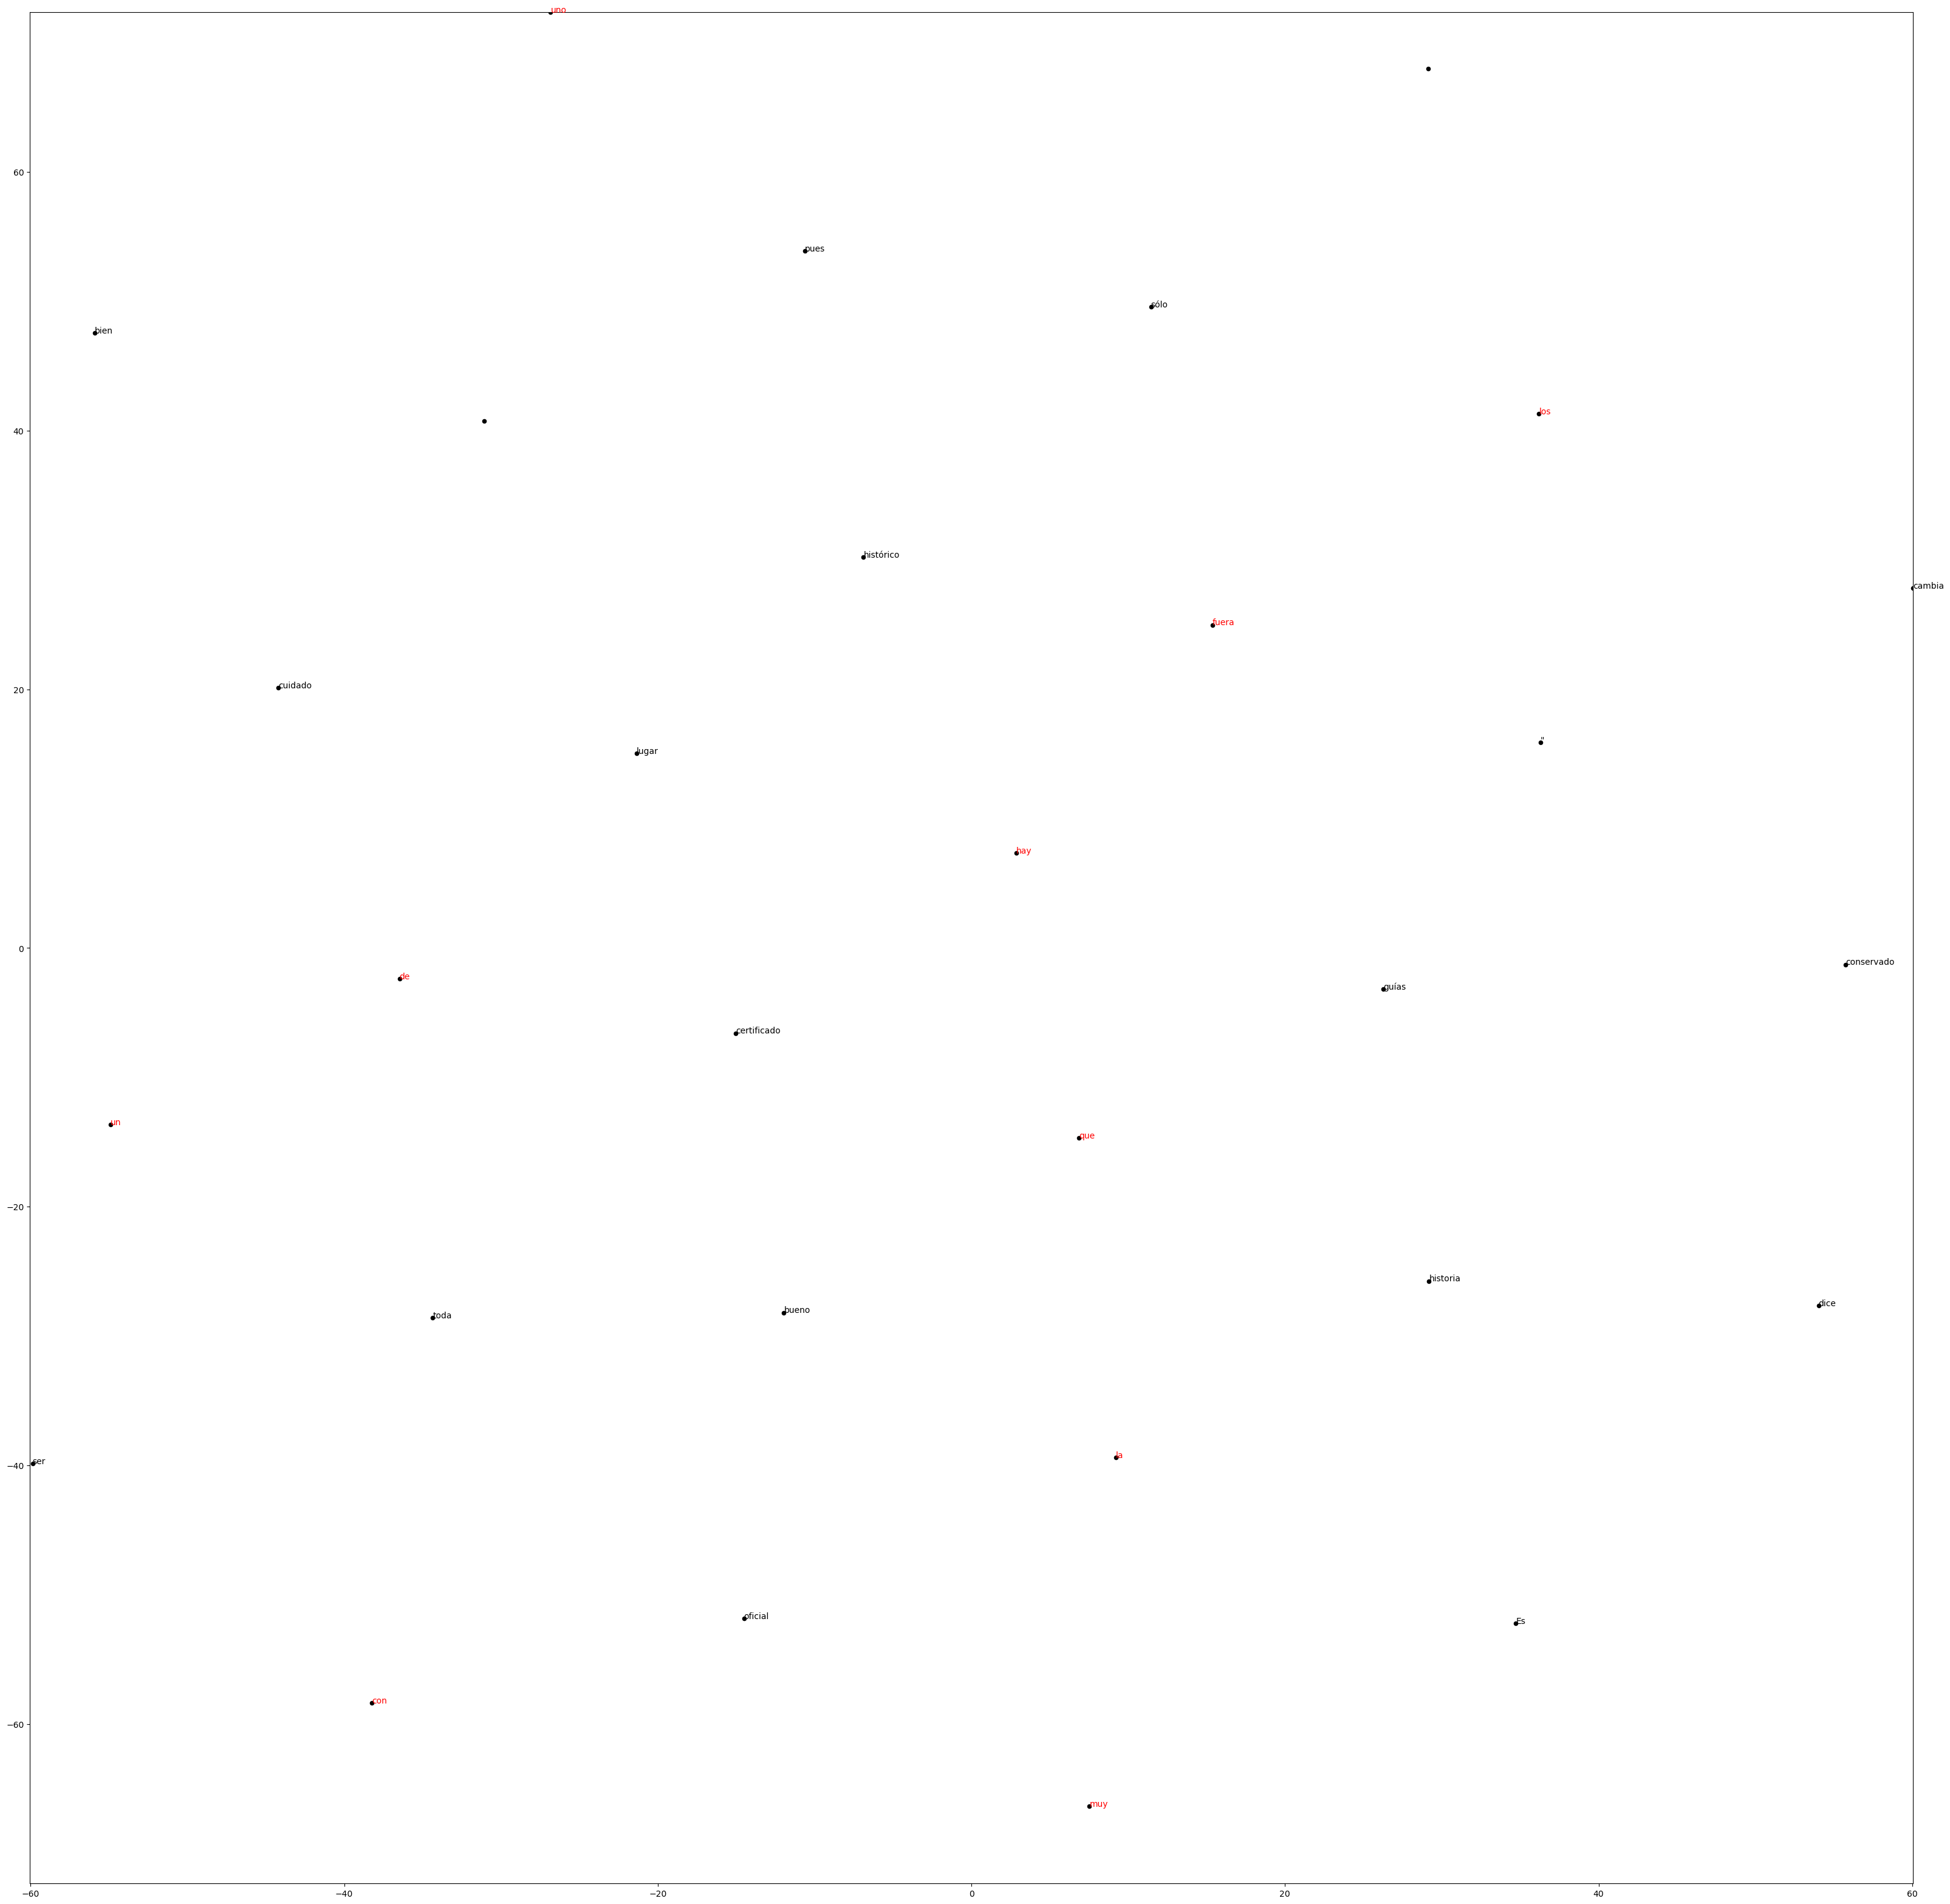

---------------
Gráfica para: Jardín de la Unión 1,134


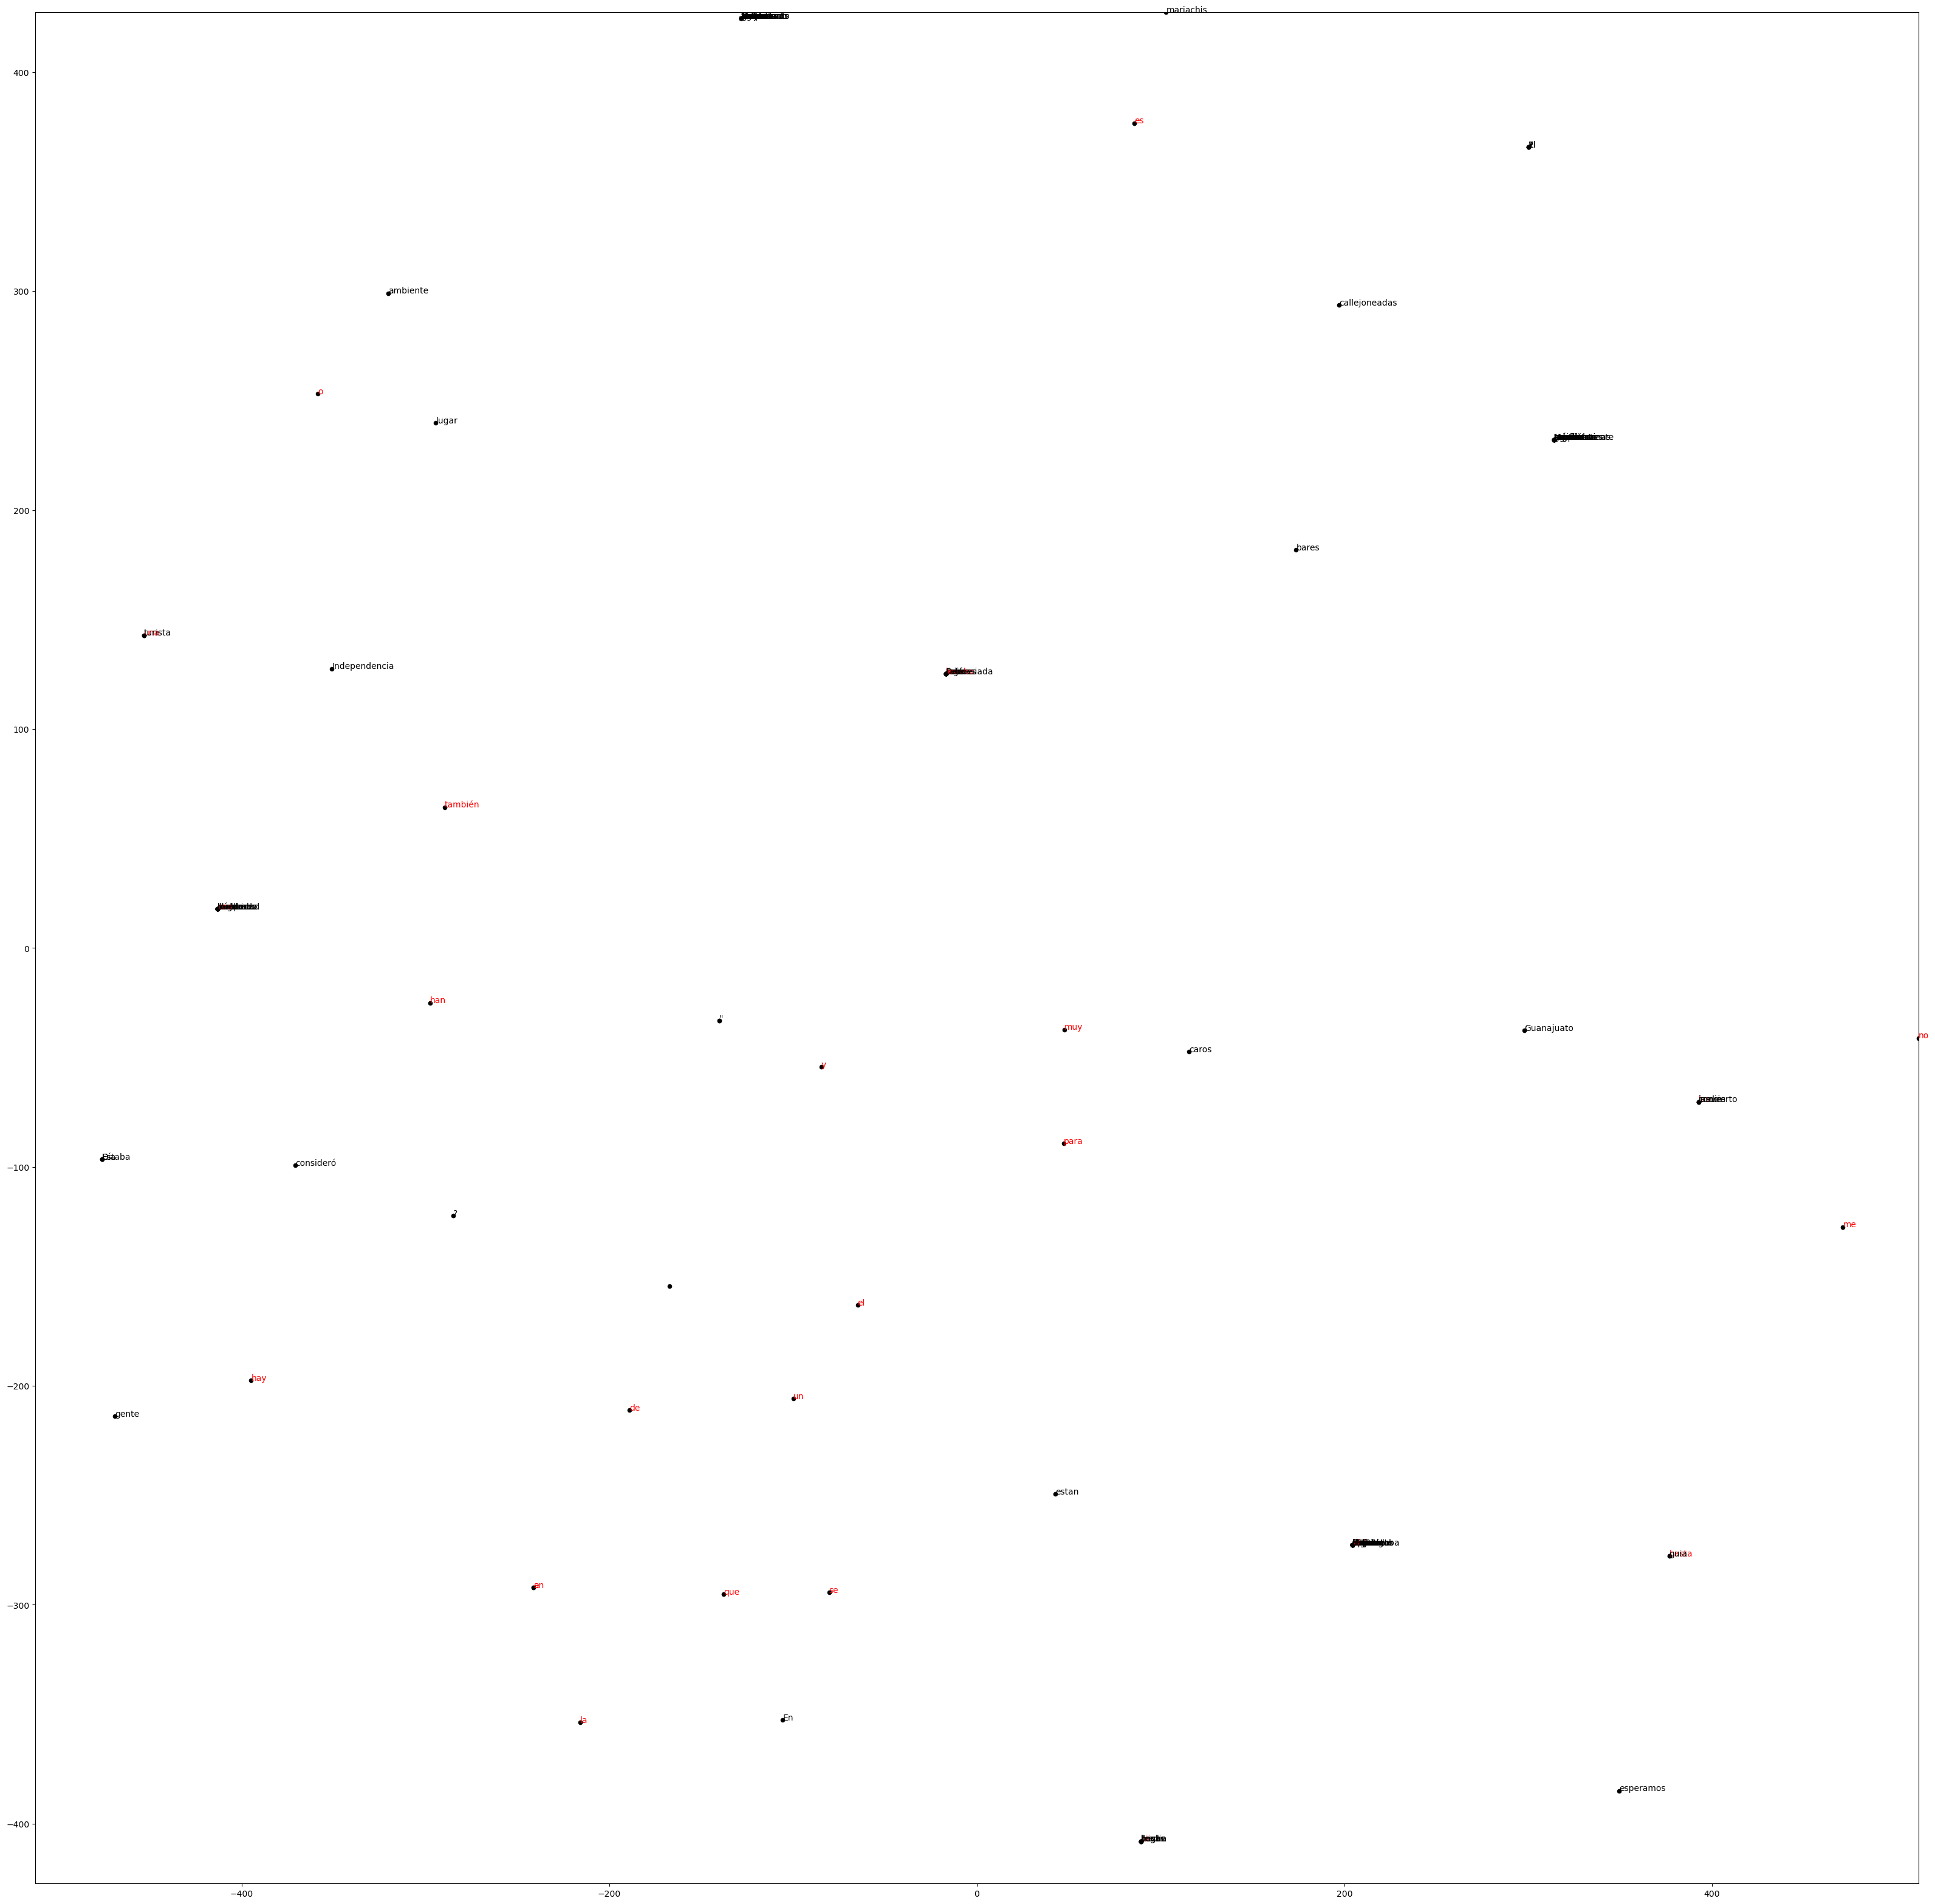

---------------
Gráfica para: Callejón del Beso 1,360


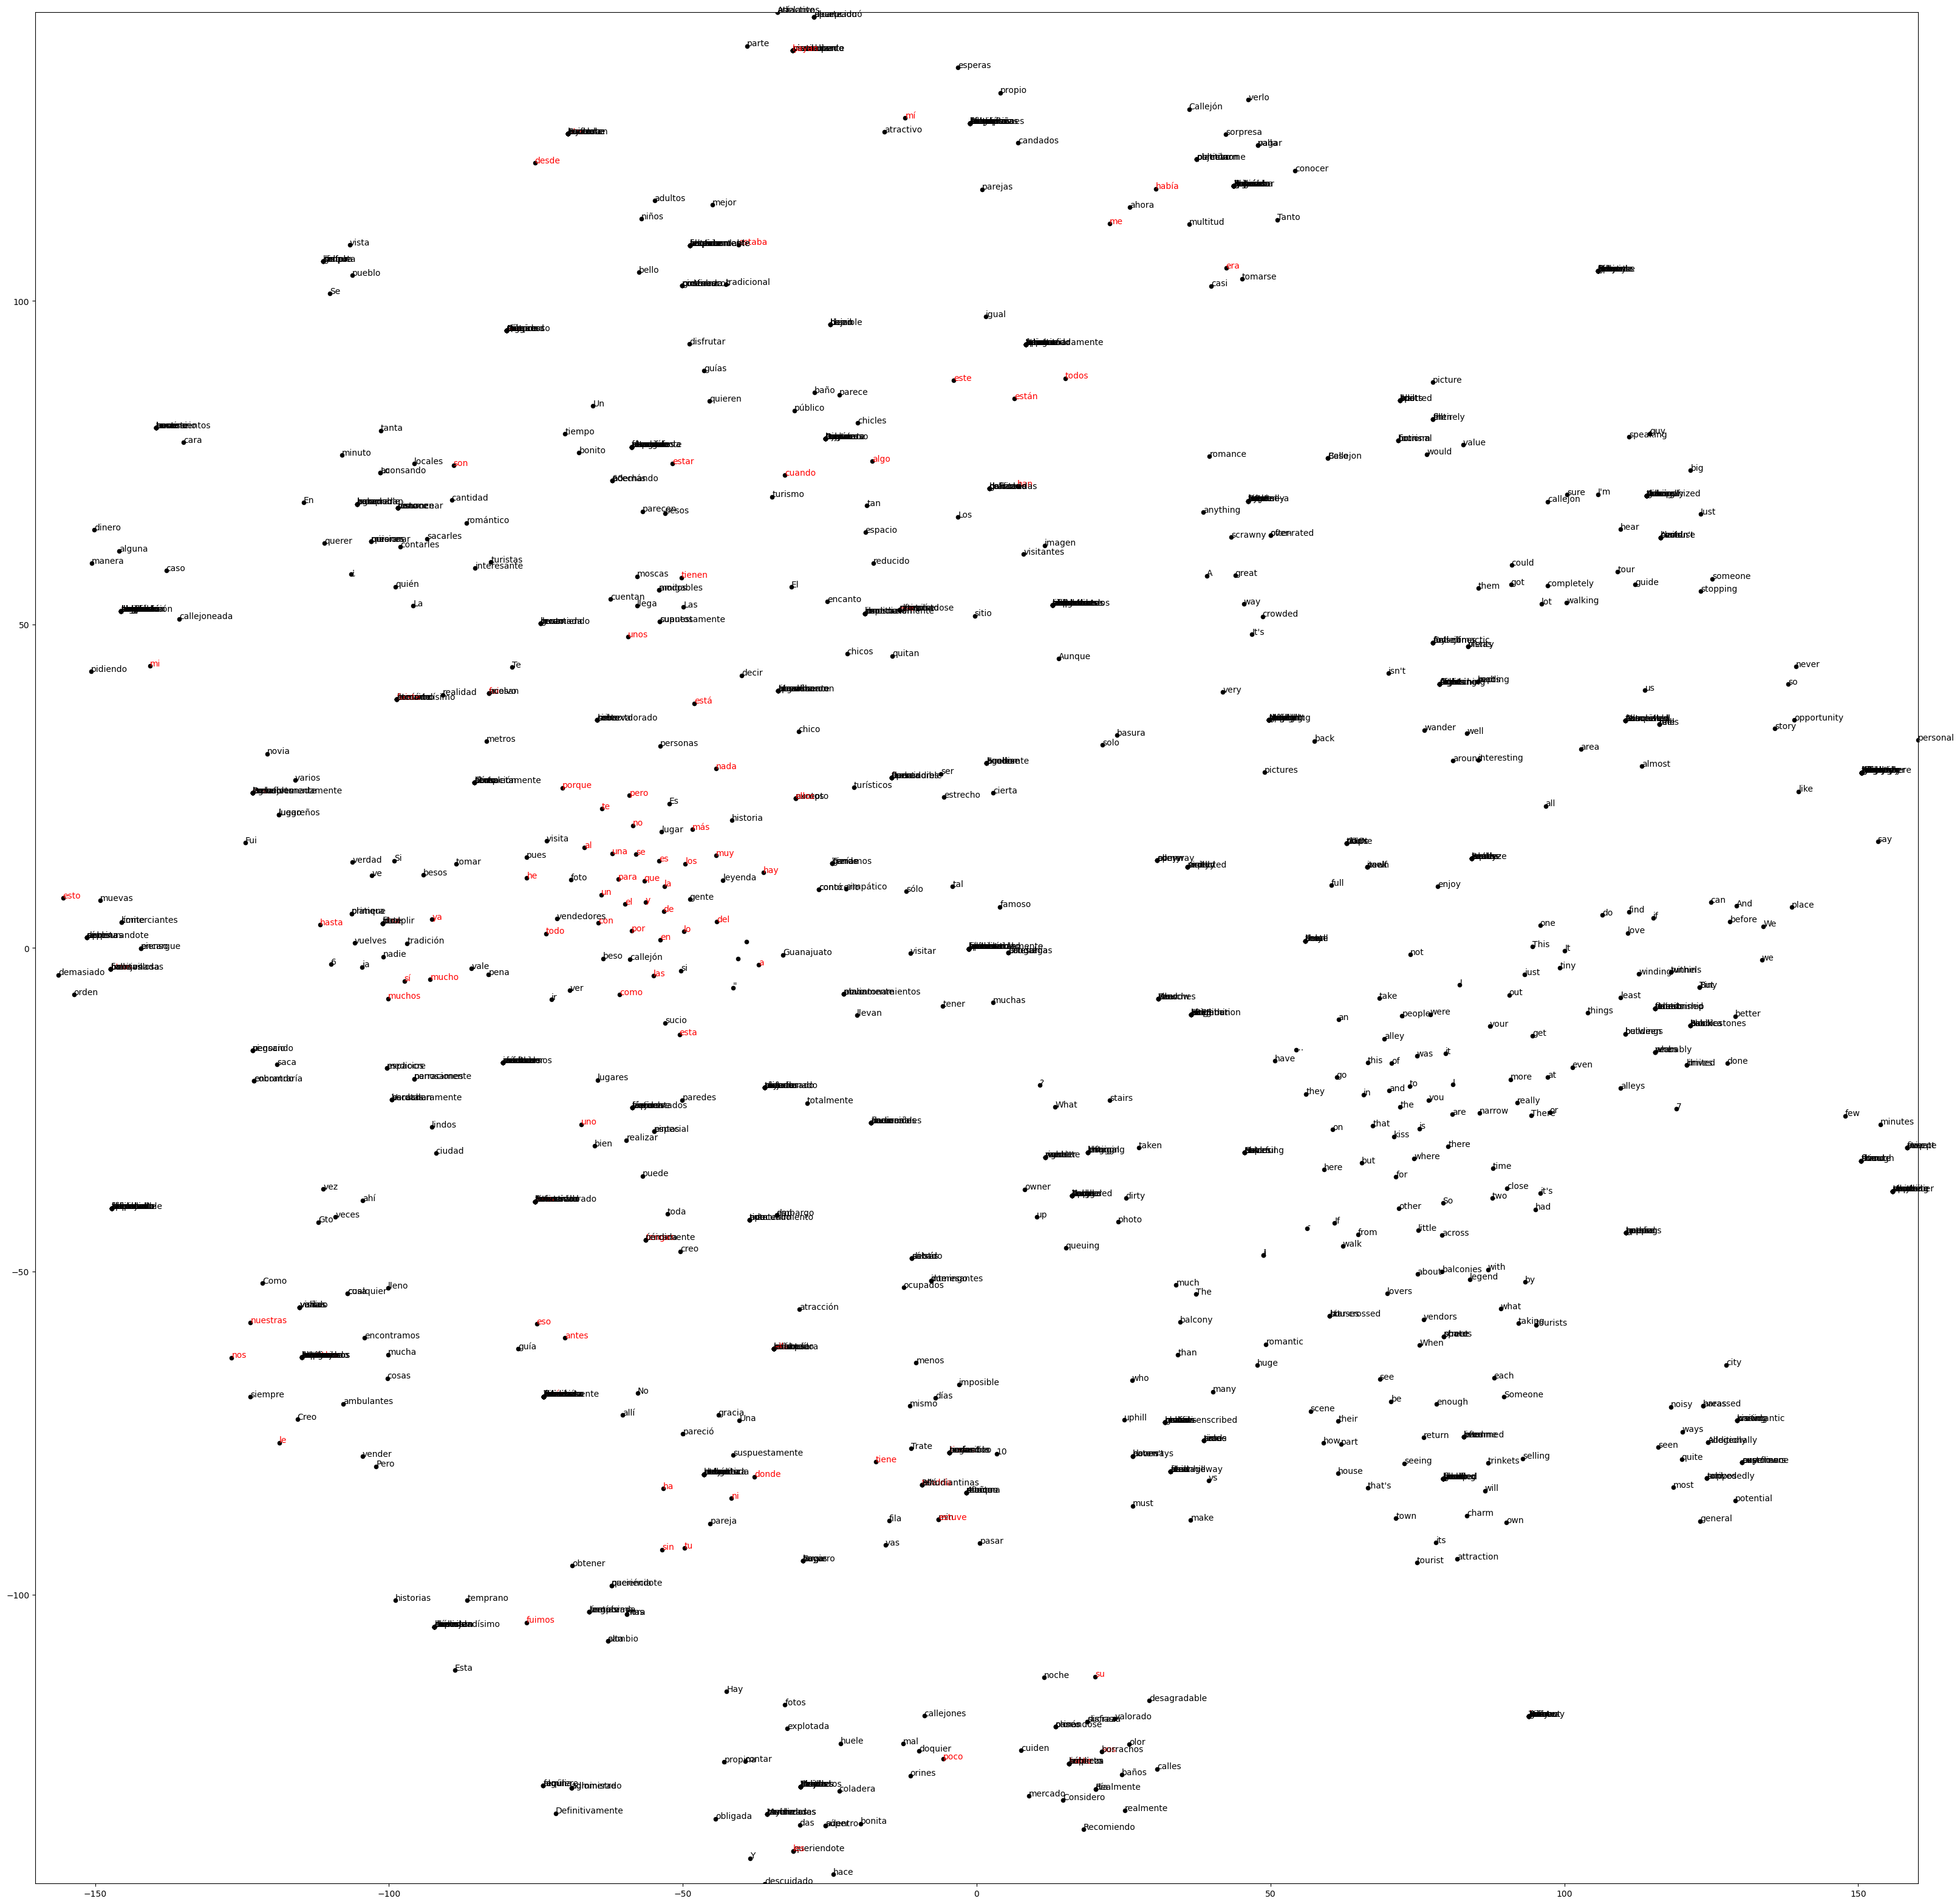

---------------
Gráfica para: Monumento Pípila 1,620


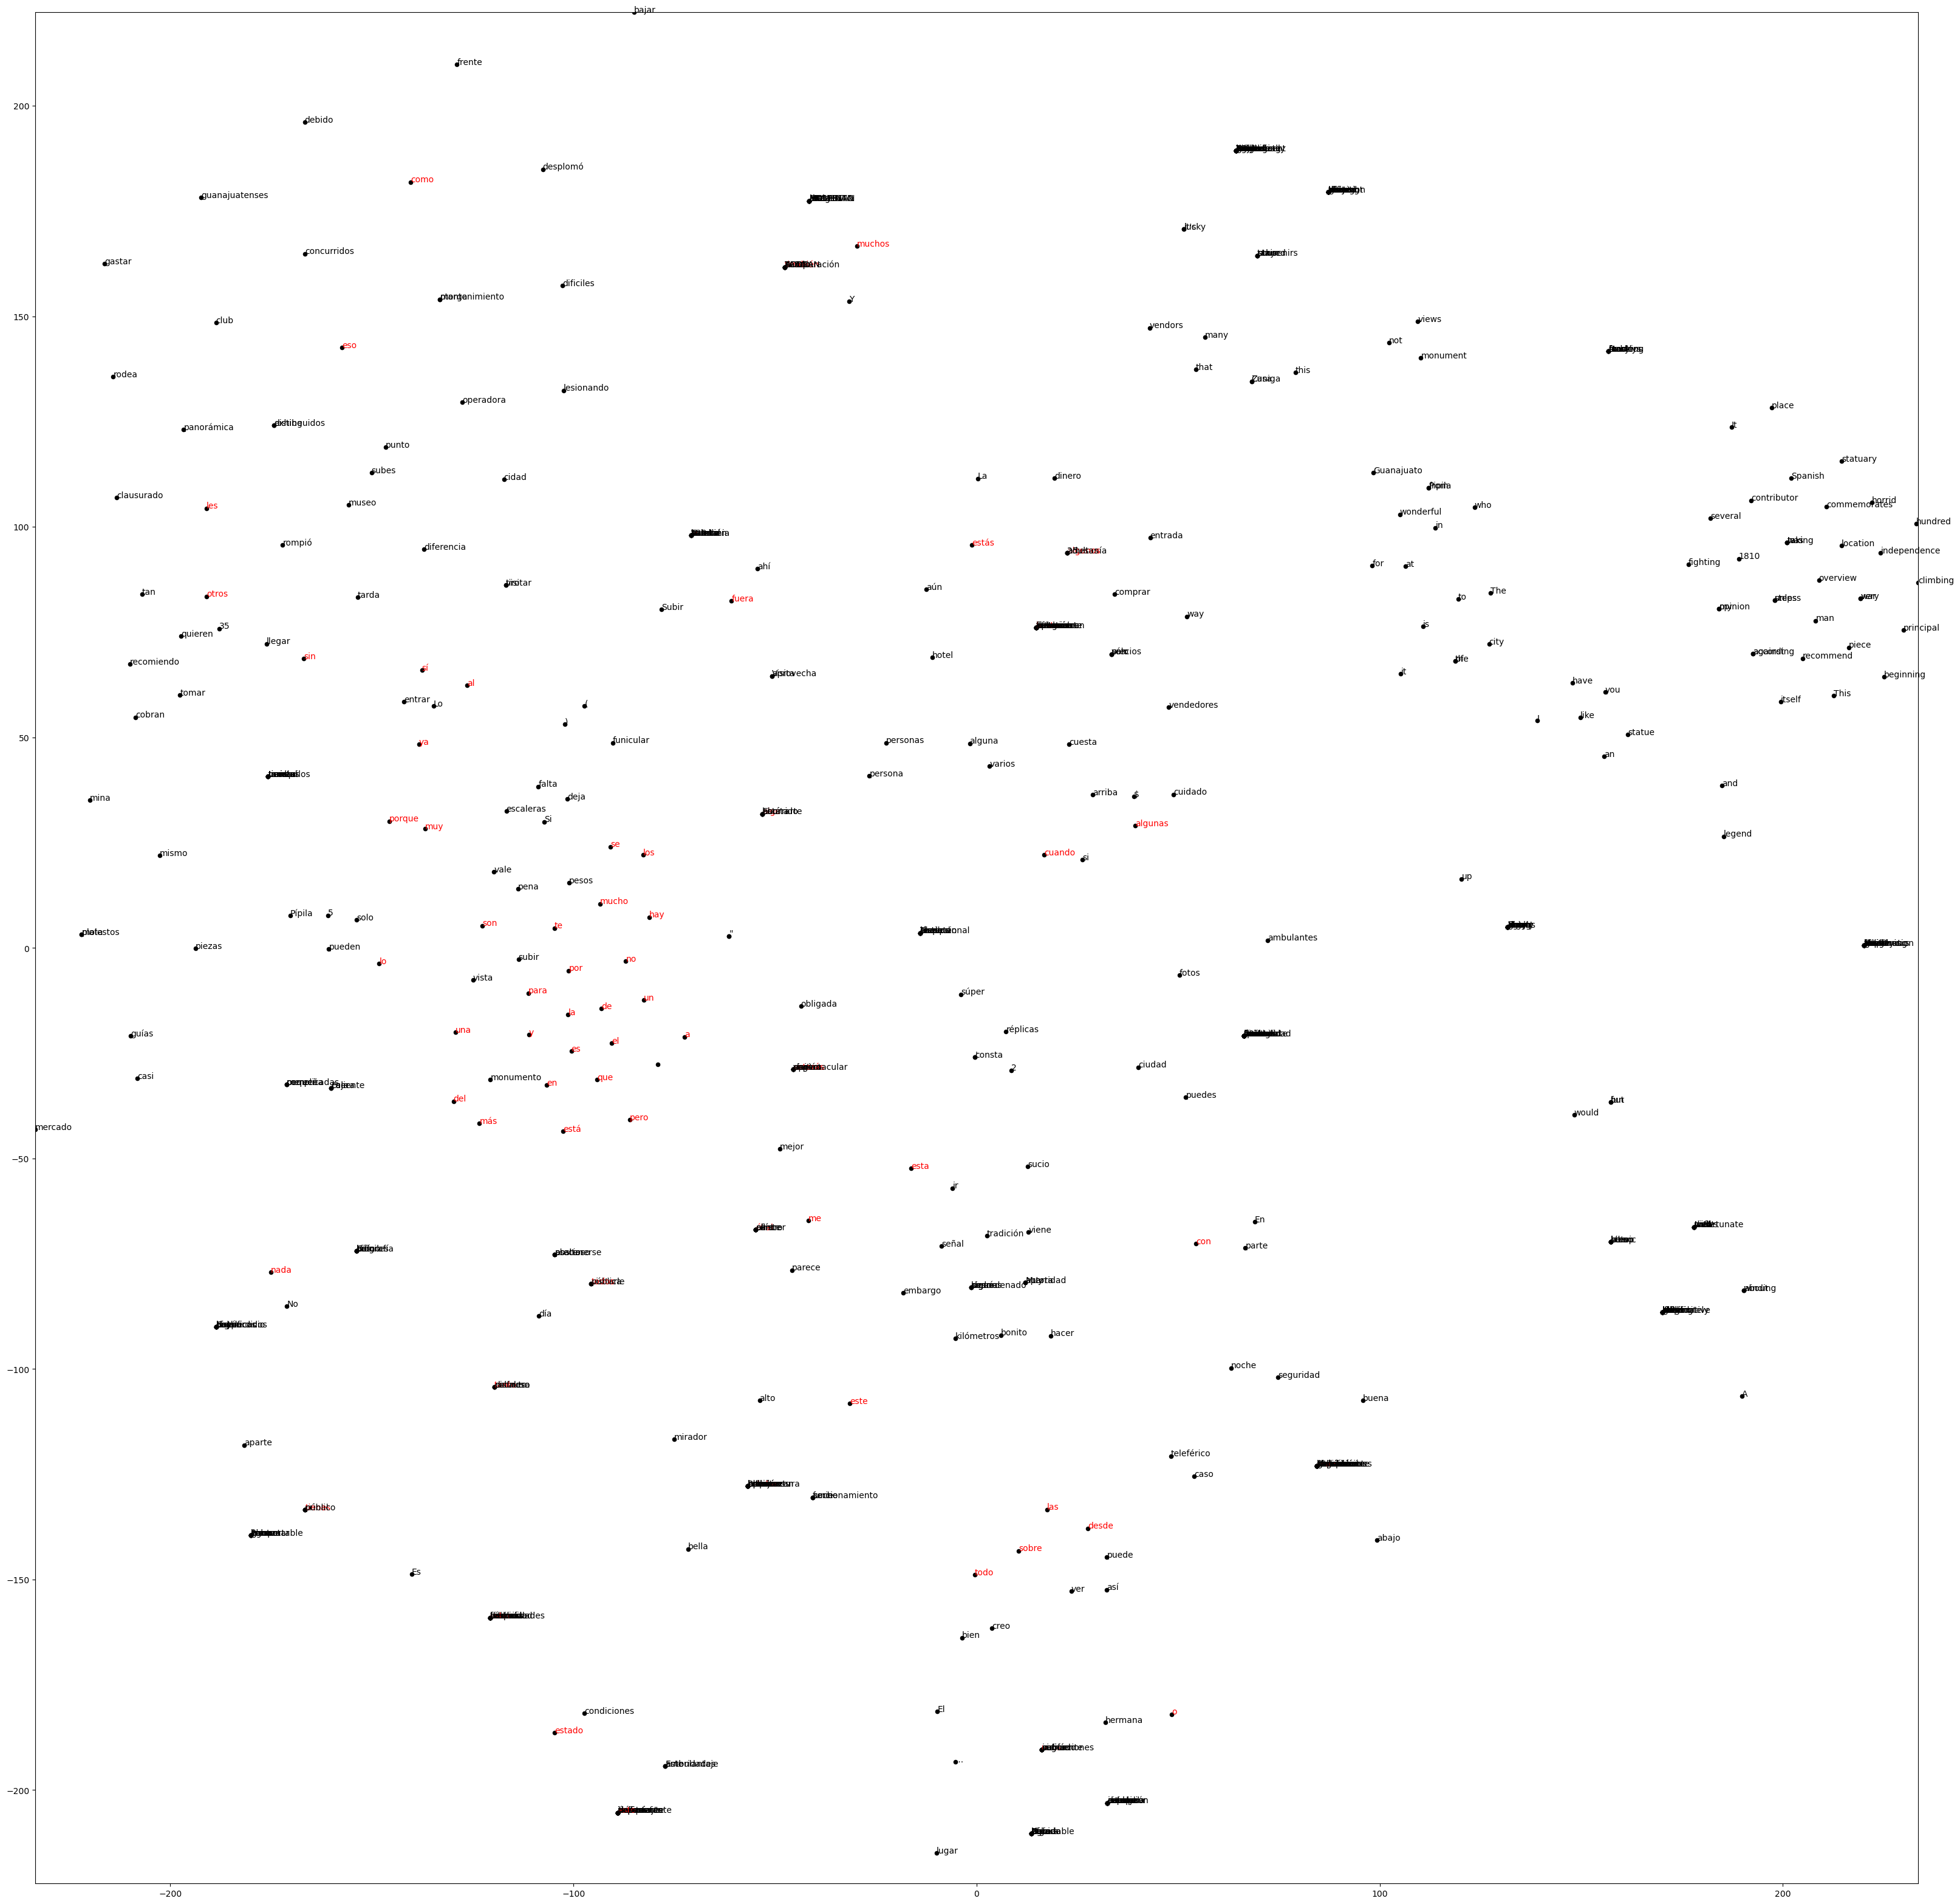

---------------
Gráfica para: Museo de las Momias 1,650


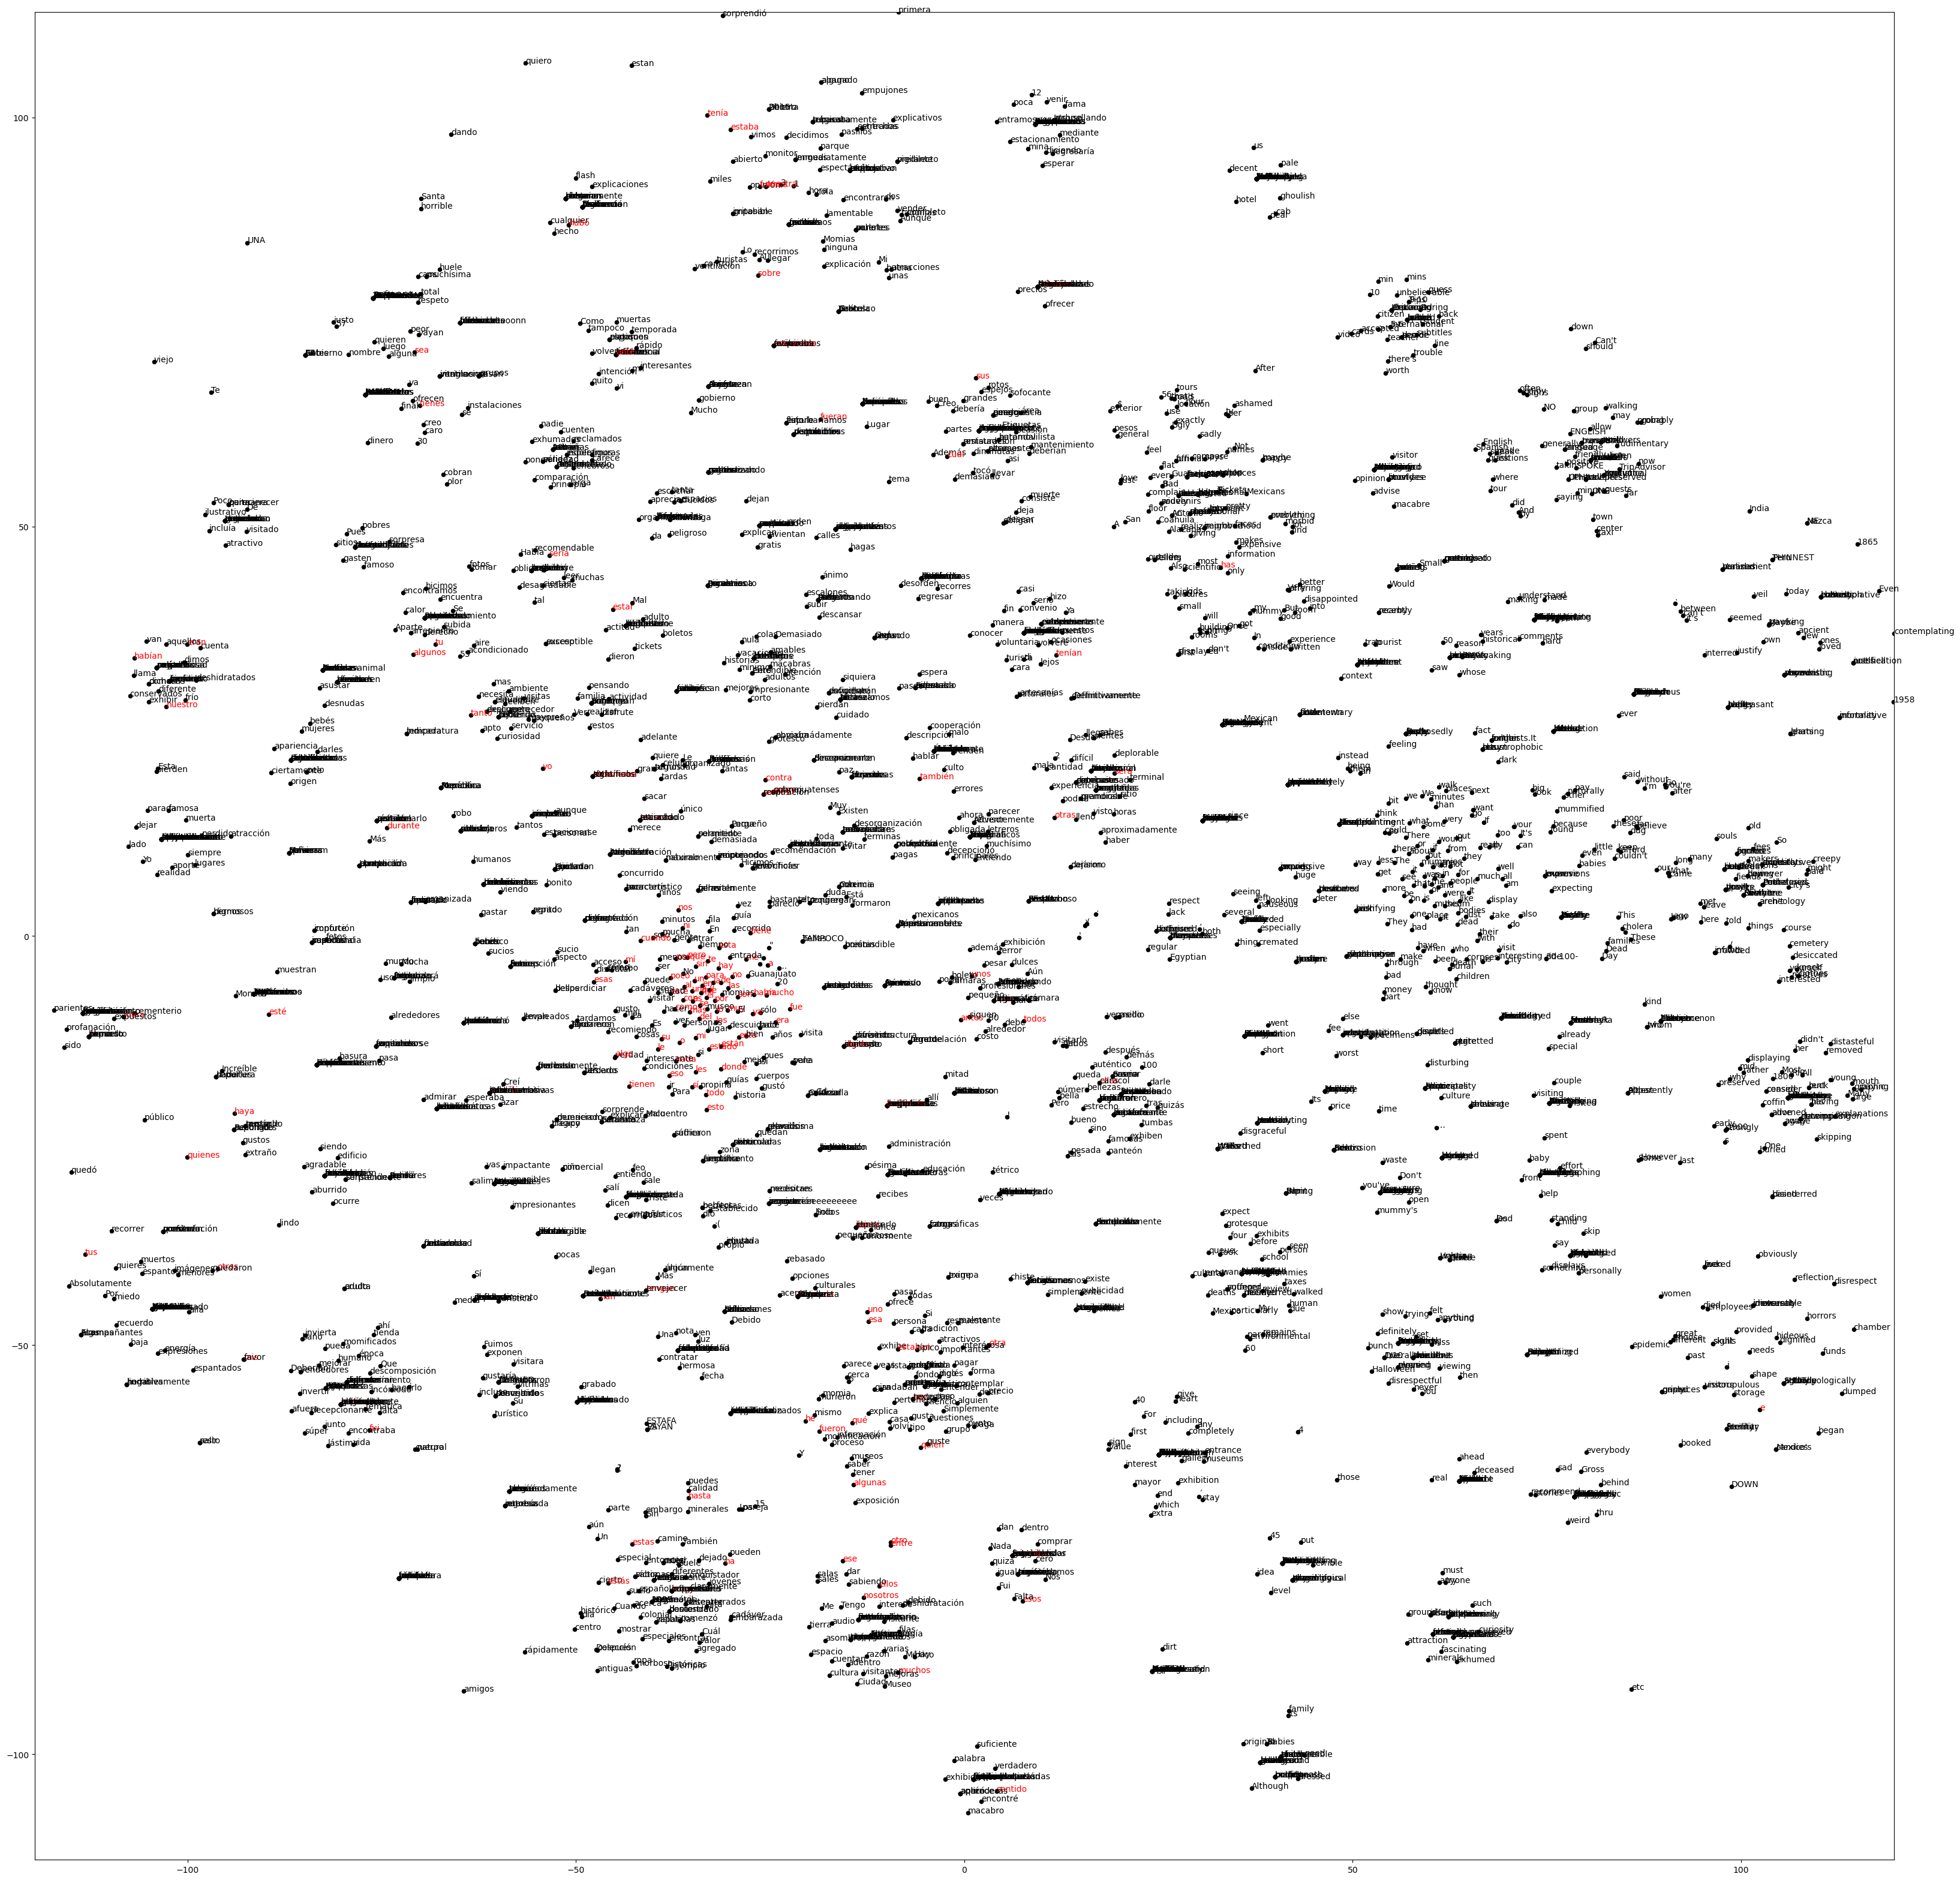

---------------


In [220]:
# Iteramos sobre cada lugar y su DataFrame en el diccionario
for lugar, df in dfs.items():
    print(f"Gráfica para: {lugar}")

    # Filtramos las opiniones mas negativas
    df = df[df['Escala'] < 3]

    # Obtenemos vocabulario
    tr_text, voc, dict_indices = GetCorpusVocDicc(df)

    # Creamos Bow y TCOR
    bow = build_bow_binary(tr_text, voc, dict_indices)
    TCOR = compute_tcor(bow)

    # Obtenemos los labels del score
    tr_labels = df["Escala"]

    # Matriz reducida
    reduced_matrix, target_words = getReducedMatrix(TCOR,bow, tr_labels, dict_indices, nWords='all')

    # Graficamos
    plotNube(reduced_matrix, target_words)

    print("---------------")

5. Para cada uno de los 10 sitios turísticos construya tres Bolsas de Palabras de la
siguiente manera: i) 1000 términos con mayor peso tfidf, ii) 2000 bigramas con mayor
tfidf, y iii) 1000 trigramas con mayor tfidf. Luego concatene las tres representaciones
que fueron calculadas de forma independiente, con sus propios tfidfs según su espacio

y su propio L2. Finalmente sobre todo ese espacio concatenado de 4000 característi-
cas aplique ganancia de información o X

2 y obtenga los 1000 features más relevantes.
Muestre una nube de palabras con el top 50 features relevantes para cada lugar turístico
(10 nubes en total).

## Preguntas

